#Titulo: Usando computación evolutiva para asignación de items a bins

Integrantes: Dylan Mayor, Josue Torres y David Milla

In [1]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt

In [2]:
class Item(object):
    def __init__(self, weight):
        self.weight = weight # Peso del item. Se impone una restriccion en el peso maximo de un bin

In [3]:
class Individual:

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = random.randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 

    def mutation_flip(self):
        "Cambia el alelo de un gen escogido aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            new_chromosome[mutGene] = 1
        else:
            new_chromosome[mutGene] = 0
        return Individual(new_chromosome)
    
    def mutation_multiflip(self):
        """
        Cambia los alelos de un conjunto de genes escogidos aleatoriamente (hasta un maximo de 50% de genes).
        """
        new_chromosome = deepcopy(self.chromosome)

        ## ESCRIBIR AQUI SU CODIGO
        random_list=[]

        max_random=random.randrange(0,len(new_chromosome)/2)

        for i in range(max_random):
          pos_random=random.randrange(0,len(new_chromosome))
          if pos_random not in random_list:
            random_list.append(pos_random)
            if new_chromosome[pos_random]==0:
              new_chromosome[pos_random]=1
            else:
              new_chromosome[pos_random]=0
          else:
            i-=1
        
        return Individual(new_chromosome)


In [4]:
def get_fitness(chromosome, items, max_weight):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los items incluidos en el cromosoma
       Si el peso total es mayor que max_weight -> el fitness es 1"""
    #fitness = 0 # initialize fitness to 0
    fitness_sum_weight = 0
    
    for i in range(len(items)):
        if chromosome[i] == 1:  # si item i esta incluido en cromosoma, acumula su valor y peso 
            fitness_sum_weight += items[i].weight
            if  fitness_sum_weight > max_weight: # si se paso del peso maximo retorna 1 como fitness
                return 1
    return fitness_sum_weight

In [5]:
def evaluate_population(population, items, max_weight):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome, items, max_weight)

In [6]:
def init_population(popsize, chromosome_size, zeroes=False):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       Si zeroes==False La inicializacion es aleatoria (por defecto), si zeroes=True los cromosomas son vectores de ceros"""
    population = []
    for i in range(popsize):
        if zeroes:
            new_chromosome = [0 for j in range(chromosome_size)]  # vector de zeros de tamaño chromosome_size
        else:
            new_chromosome = [random.randint(0,1) for j in range(chromosome_size)]  #vector aleatorio de 0s y 1s de tamaño chromosome_size
        
        population.append( Individual(new_chromosome) )
    return population

In [7]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

In [8]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

In [9]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

In [10]:
def genetic_algorithm(poblacion_inicial, items, max_weight, ngen=100, pmut=0.1, 
                      crossover="onepoint", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """Algoritmo Genetico para el problema de la mochila
        items:      pool de items a escoger para la mochila. 
                    Debe ser una lista de objetos de clase Item
        max_weight: maximo peso que puede soportar la mochila
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    
    population = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la inicial
    
    popsize = len(population)
    evaluate_population(population, items, max_weight)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                elif mutation == "multiflip":
                    offspring_population[i] = offspring_population[i].mutation_multiflip() # invierte todos los genes entre 2 puntos al azar
                else:
                    raise NotImplementedError   
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, items, max_weight)   # evalua la poblacion descendencia
        
        ## Selecciona individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError
            
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        if (g % 10 == 0):  # muestra resultados cada 10 generaciones
            print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))
        
    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness , population[ibest[0]].chromosome  # devuelve el mejor individuo y la lista de mejores fitness x gen

#Desde aqui se genera la cantidad de los items y el valor de los pesos a utilizar de manera aleatoria

In [118]:
# Hay que hacer con elementos que no se repitan

NUM_ITEMS = 10        # numero de items
MAX_ITEM_WEIGHT = 25  # maximo peso posible de cada  item
Random_items=[]

i=0

while i < NUM_ITEMS:
  random_weight=random.randint(10,MAX_ITEM_WEIGHT)*5
  if random_weight not in Random_items:
    Random_items.append(random_weight)
    i+=1

In [119]:
#Validamos que los numeros aleatorios no se repiten
Random_items

[60, 50, 85, 110, 115, 125, 80, 100, 95, 70]

In [120]:
#pool de items
ItemPool = [ Item(Random_items[x]) for x in range (0,NUM_ITEMS) ]
MAX_WEIGHT = 15*len(ItemPool)    # maximo peso que puede soportar cada BIN


In [121]:
#Se muestra la informacion en modo de items

for i in range(len(ItemPool)):
  print("  peso: " + str(ItemPool[i].weight))

  peso: 60
  peso: 50
  peso: 85
  peso: 110
  peso: 115
  peso: 125
  peso: 80
  peso: 100
  peso: 95
  peso: 70


In [134]:
import statistics

#Aqui se emplea el algoritmo genetico con 0 en tasa de mutacion y metodo de cruzamiento uniforme

Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 1, 0] (fitness = 145)


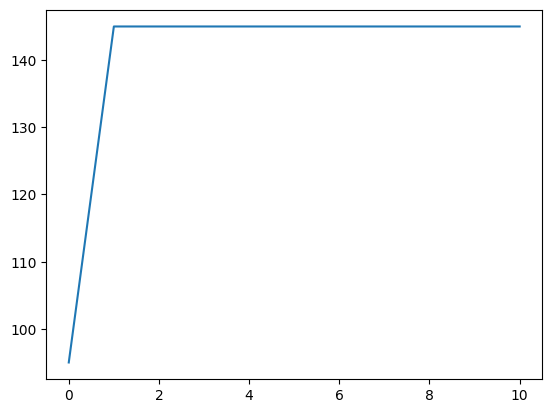

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


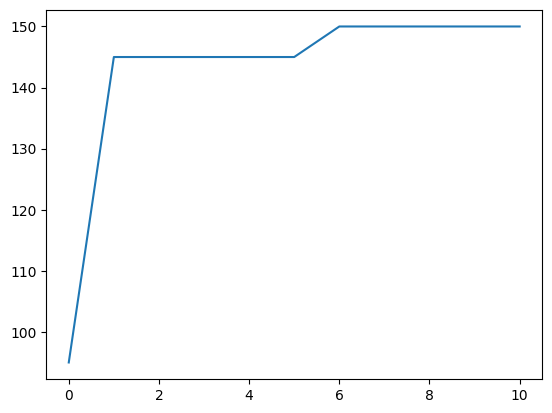

----------------------------------------
maxima posicion:  6
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 1, 0] (fitness = 145)


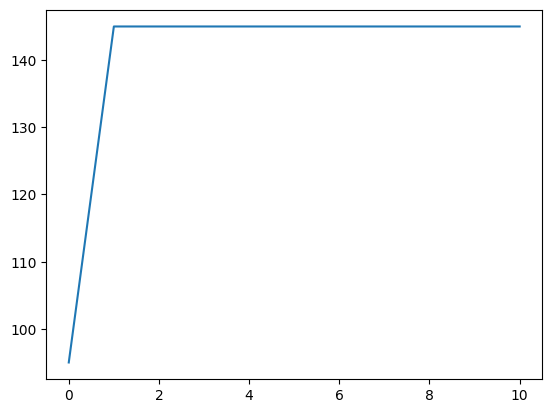

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 1, 0] (fitness = 145)


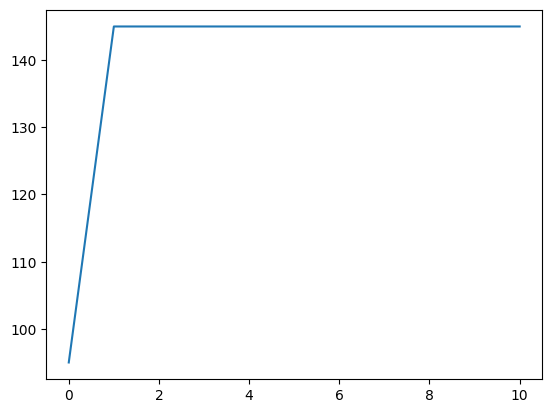

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] (fitness = 145)


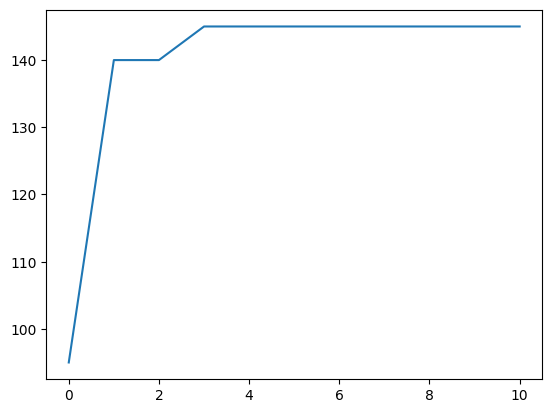

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


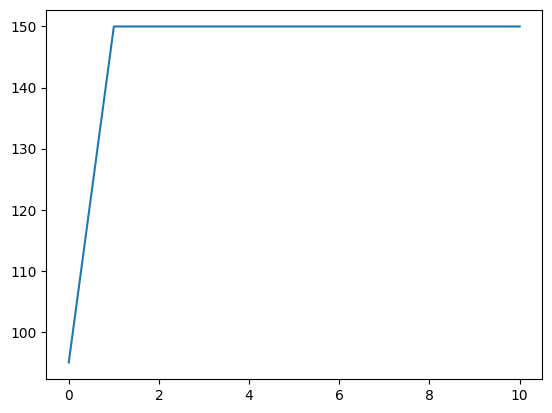

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


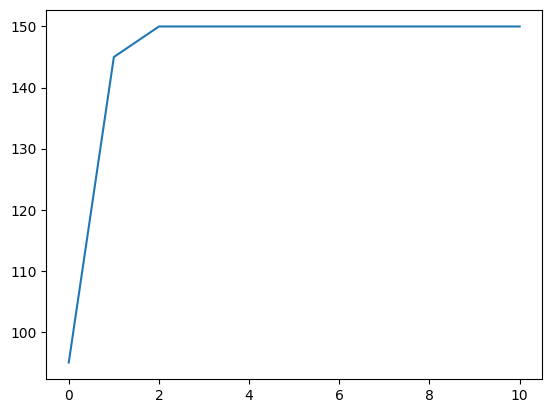

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


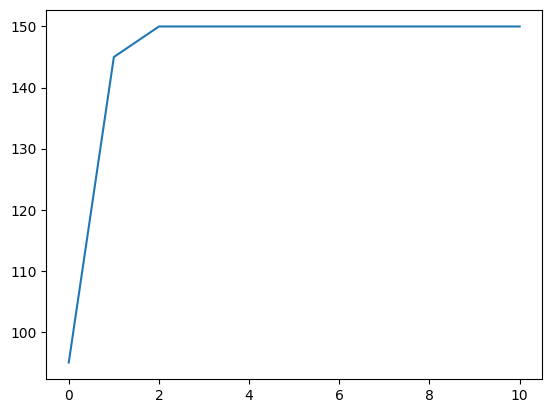

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 1, 0] (fitness = 145)


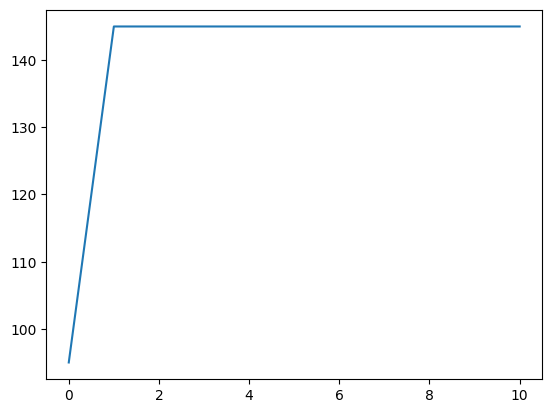

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 95
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


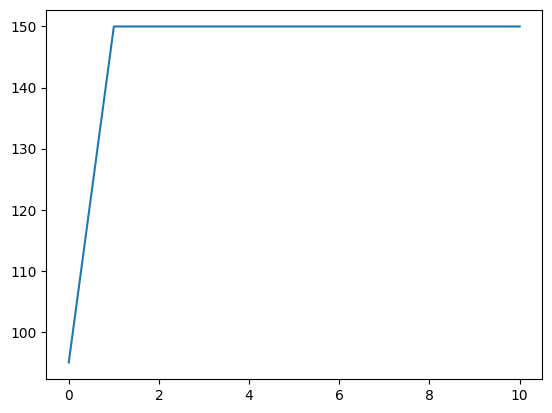

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


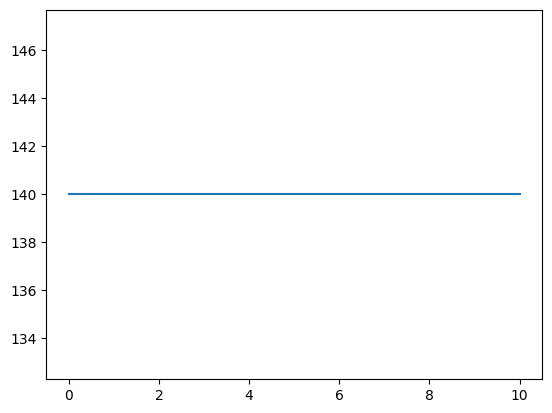

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


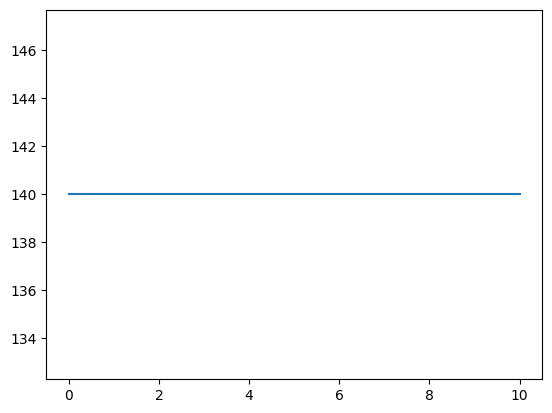

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


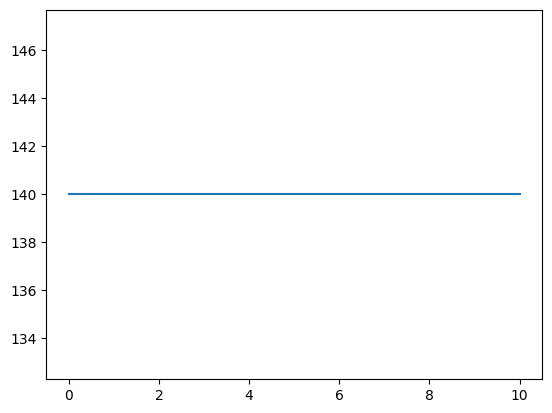

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


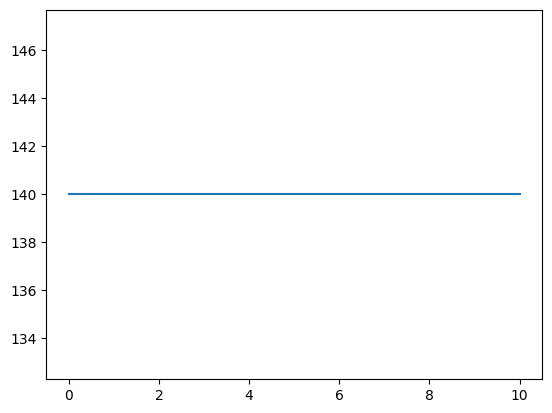

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


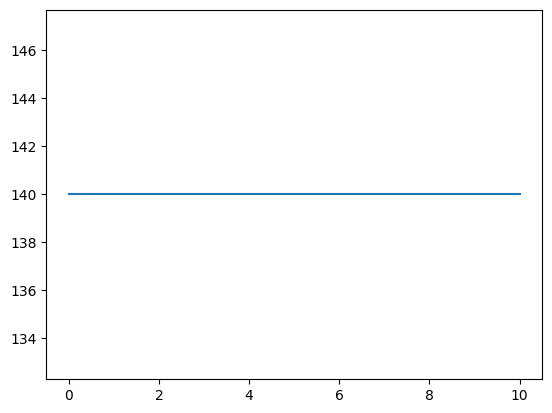

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


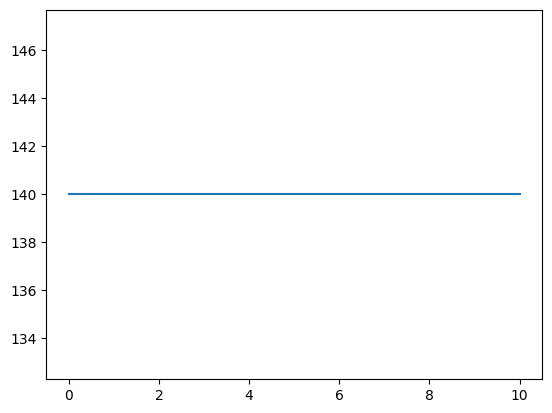

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


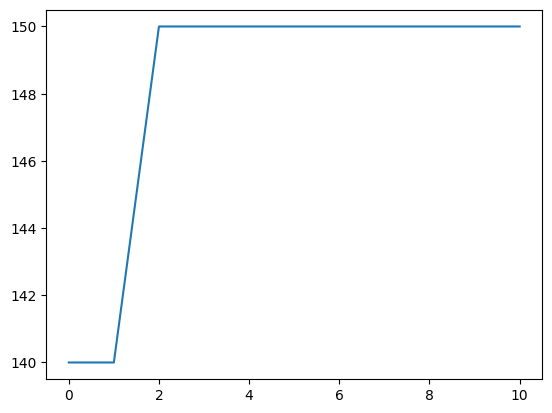

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [1, 0, 0, 0, 0, 1, 0, 0] (fitness = 140)


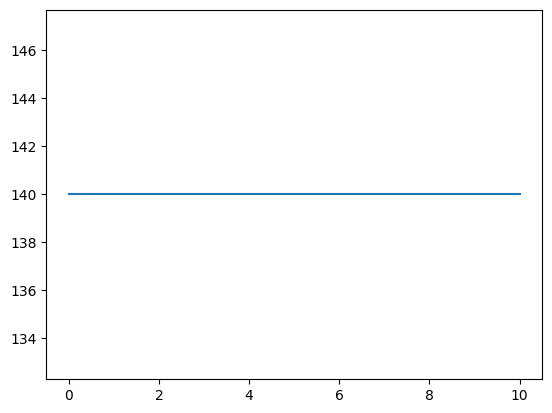

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


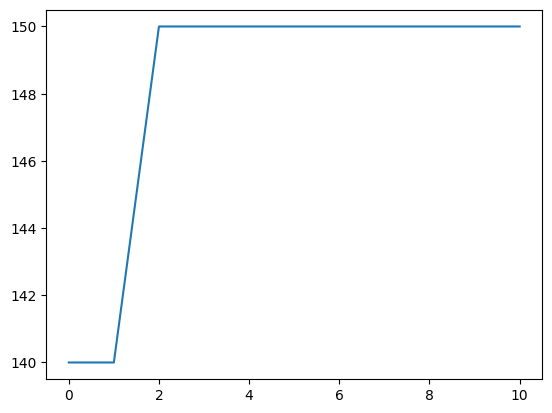

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


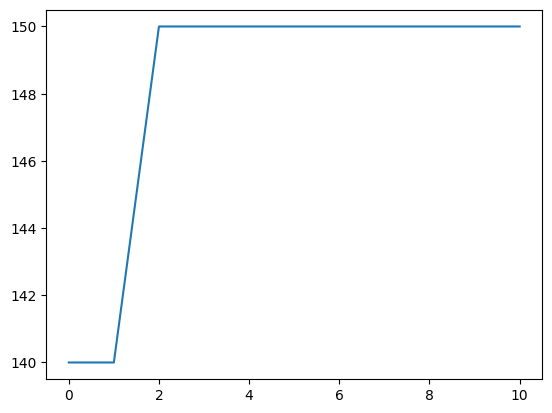

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


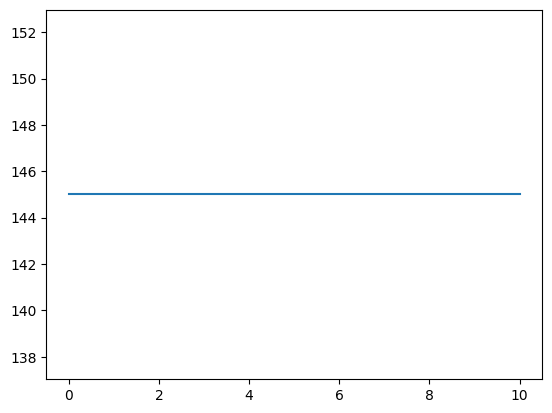

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


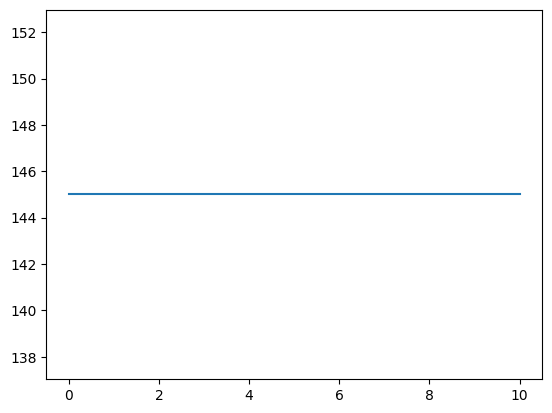

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


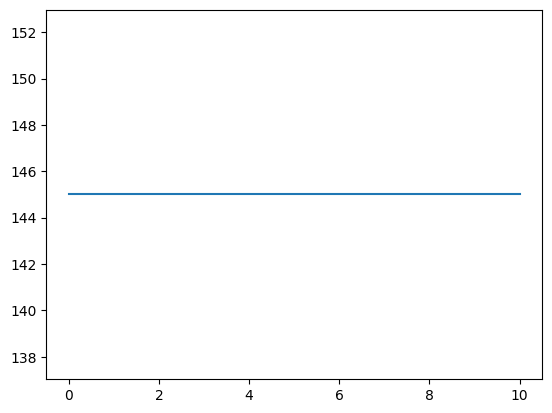

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


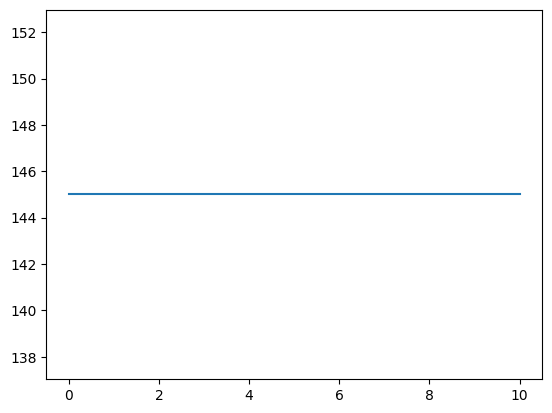

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


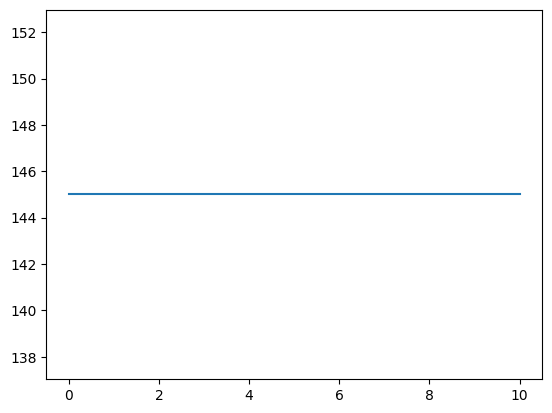

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


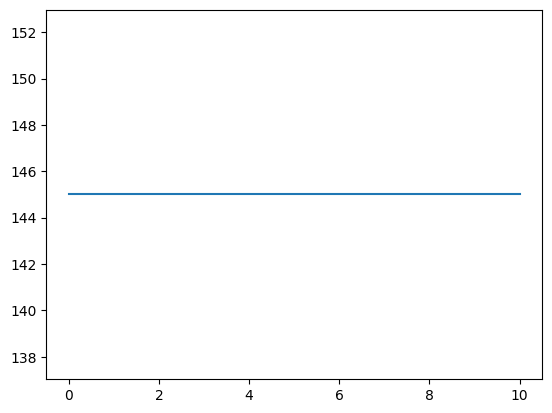

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


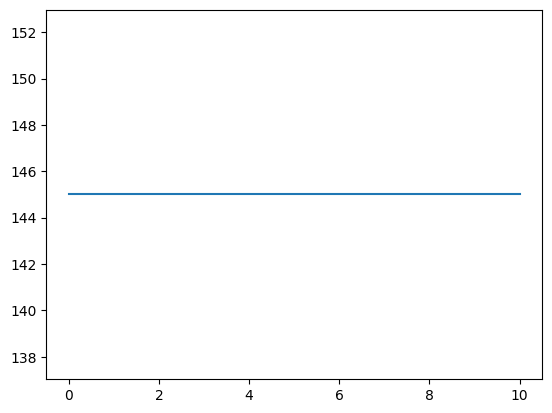

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


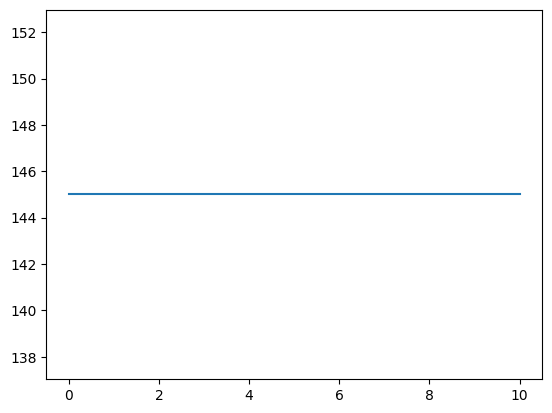

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


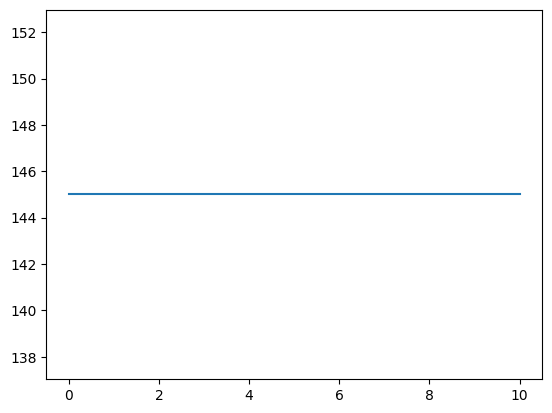

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


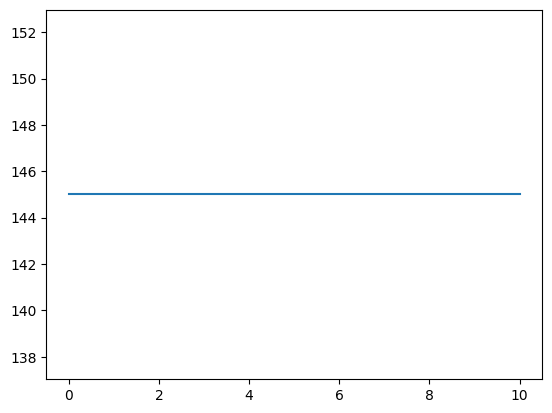

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


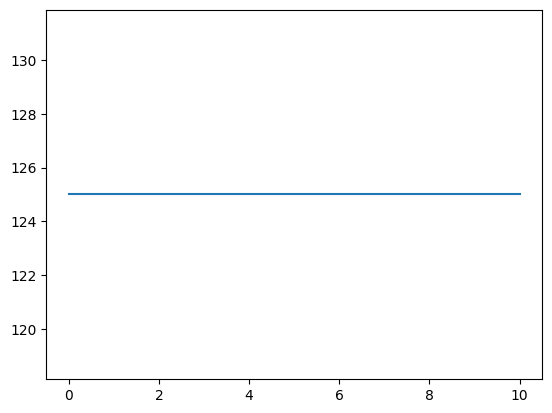

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


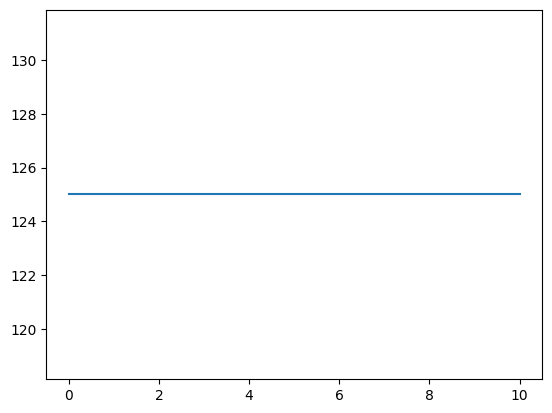

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


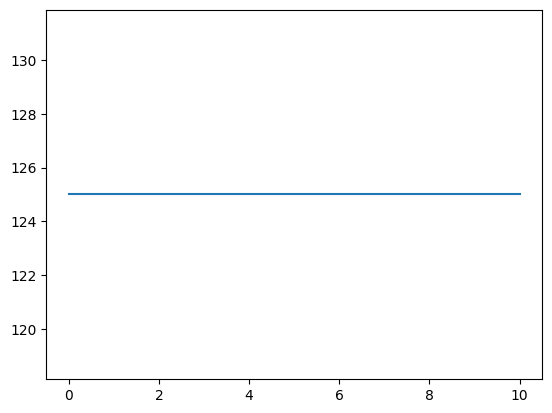

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


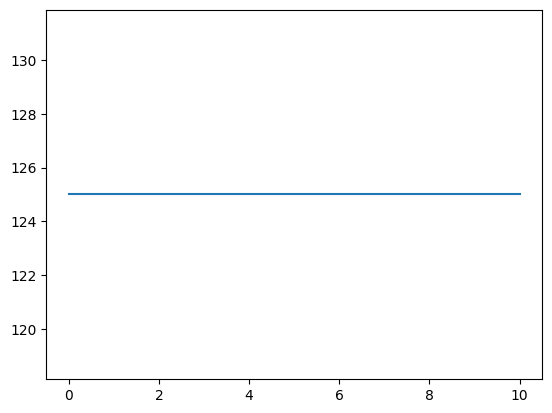

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


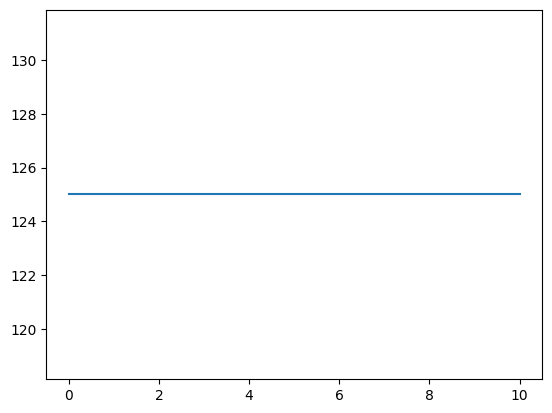

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


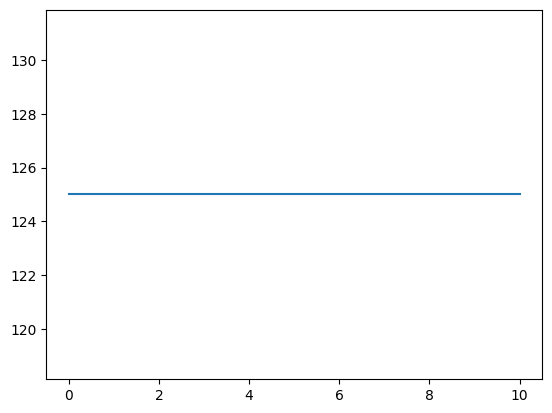

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


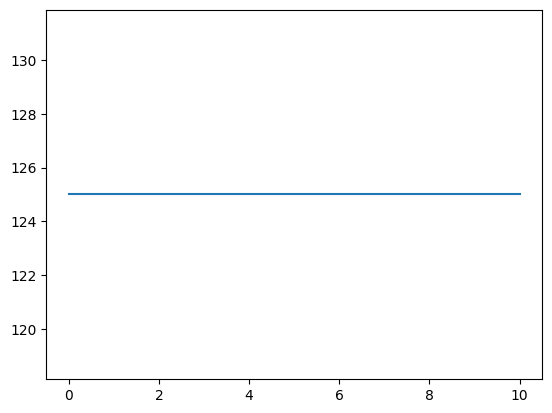

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


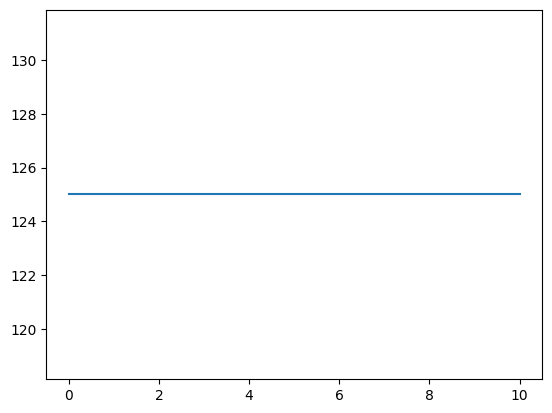

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


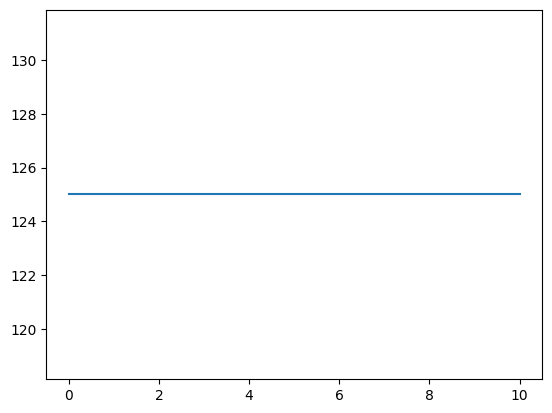

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


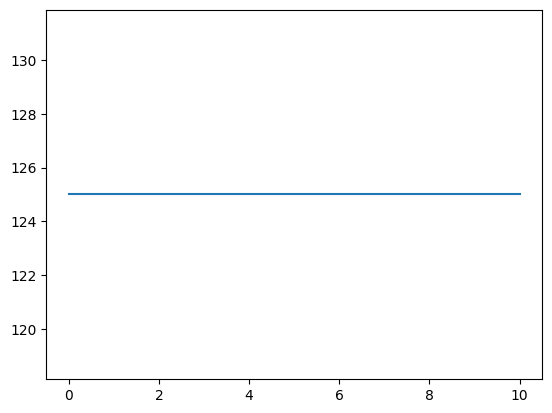

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


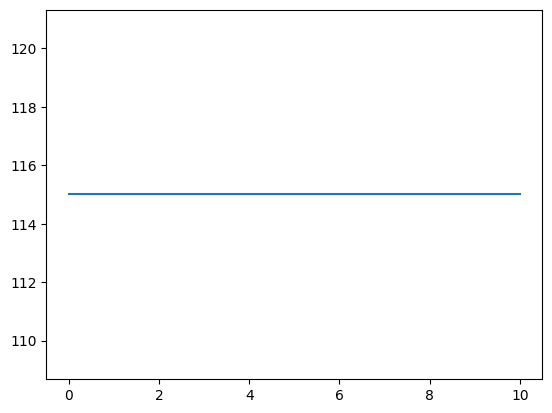

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


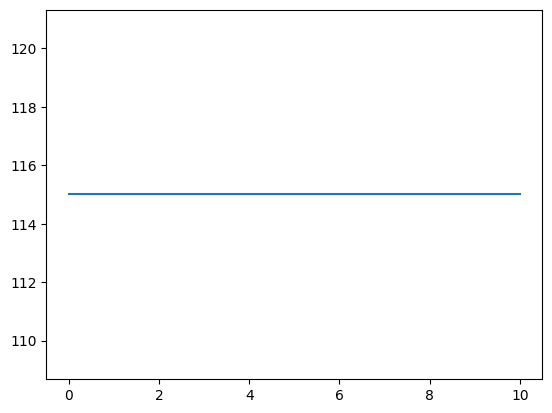

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


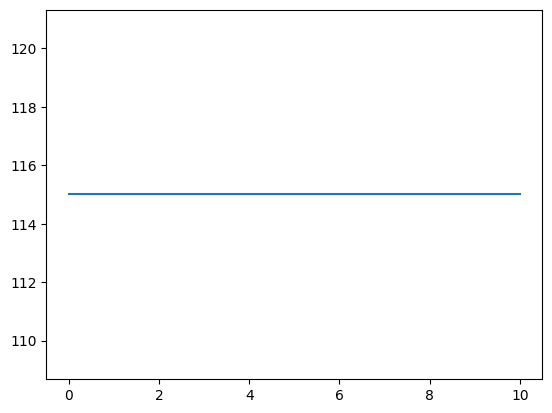

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


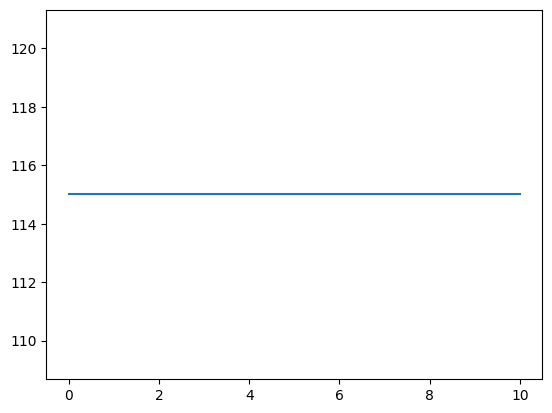

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


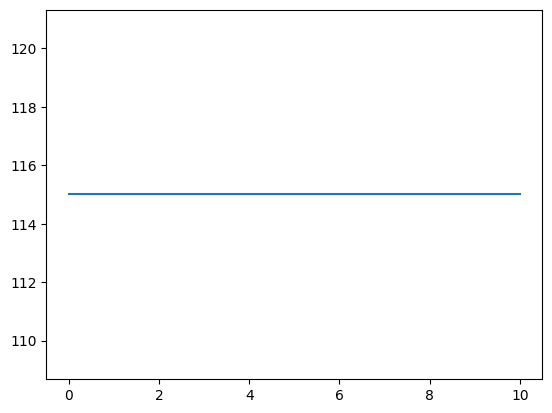

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


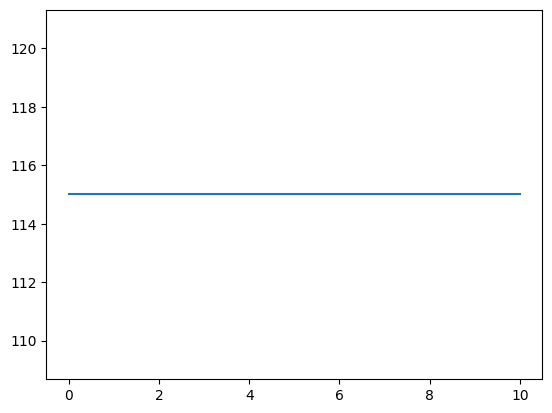

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


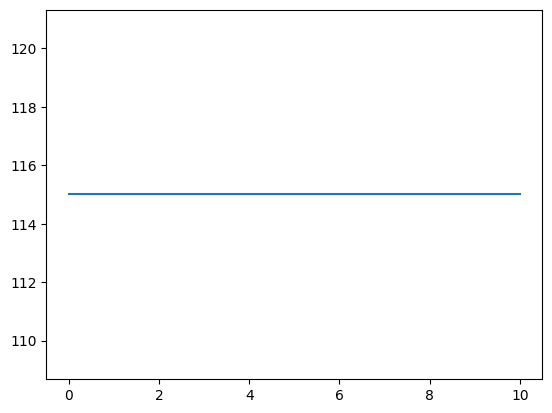

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


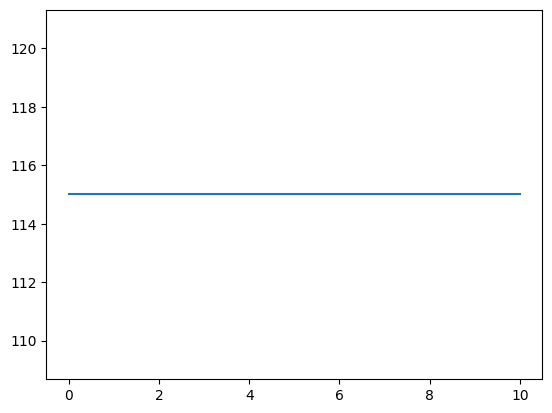

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


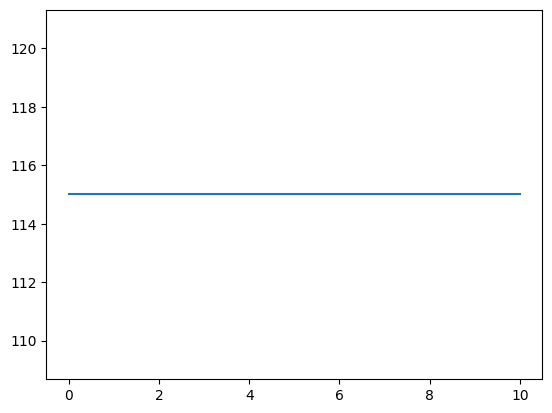

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


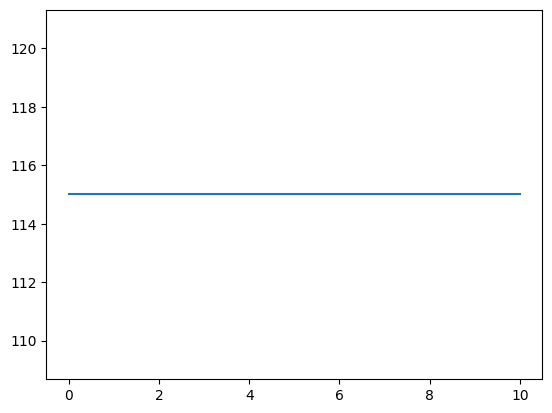

----------------------------------------
maxima posicion:  0
----------------------------------------


In [165]:
## Hiperparametros del algoritmo genetico

ItemPool = [ Item(Random_items[x]) for x in range (0,NUM_ITEMS) ]
MAX_WEIGHT = 15*len(ItemPool)    # maximo peso que puede soportar cada BIN


POPSIZE = 50       # numero de individuos
GENERATIONS = 10   # numero de generaciones
PMUT = 0       # taza de mutacion
NUM_BINS=5

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)
Items_guardados_bin=[]      #Almacenar el valor de los pesos de cada BIN
Elementos_no_elegidos=[]    #Almacenar los pesos que no fueron colocados en ningun BIN al culminar el proceso


mean_first_generation=[]
mode_first_generation=[]

for j in range(NUM_BINS):
  array_first_generation_max=[]
  for i in range(10):
    best_ind, bestfitness, index_fitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, PMUT, 
                                              crossover="uniform", mutation="flip", 
                                              selection_parents_method = 'roulette', 
                                              selection_survivors_method = 'ranking')

    
    plt.plot(bestfitness)
    plt.show()

    max_pos=0
    max_valor=0

    for k in range(len(bestfitness)):
      if bestfitness[k]>max_valor:
        max_valor=bestfitness[k]
        max_pos=k

    array_first_generation_max.append(max_pos)
    print("-"*40)
    print("maxima posicion:  " + str(max_pos))
    print("-"*40)
  mean=statistics.mean(array_first_generation_max)
  moda=statistics.mode(array_first_generation_max)

  mean_first_generation.append(mean)
  mode_first_generation.append(moda)

  #Guardar items de cada BIN
  Item_en_bin=[]
  

  for z in range(len(ItemPool)):
    if index_fitness[z]==1:
      Item_en_bin.append(ItemPool[z])

  Items_guardados_bin.append(Item_en_bin)

  #Actualiza los items faltantes y la poblacion nueva
  Aux_item_pool=ItemPool
  ItemPool=[]
  for q in range(len(Aux_item_pool)):
    if index_fitness[q]==0:
      ItemPool.append(Aux_item_pool[q])

  poblacion_inicial =  init_population(POPSIZE, len(ItemPool))

  if j==(NUM_BINS-1):
    for p in range(len(Aux_item_pool)):
      if index_fitness[p]==0:
        Elementos_no_elegidos.append(Aux_item_pool[p])


In [166]:
mean_first_generation

[1.9, 0.6, 0, 0, 0]

In [167]:
mode_first_generation

[1, 0, 0, 0, 0]

#Aqui se muestra los BINs definidos y los pesos en cada uno de ellos

In [168]:
Area_total_no_usada=0

print("Metodo de cruzamiento uniforme y tasa de mutacion 0")

for k in range(len(Items_guardados_bin)):
  Area_usada=0
  print("Para el bin numero {}".format(k+1))
  for i in range(len(Items_guardados_bin[k])):
    print("  peso: " + str(Items_guardados_bin[k][i].weight))
    Area_usada+=Items_guardados_bin[k][i].weight
    
  print("Area no usada: " + str(150-Area_usada) + "\n"+"-"*40)
  Area_total_no_usada+=(150-Area_usada)

print("Area total no usada: " + str(Area_total_no_usada))

Metodo de cruzamiento uniforme y tasa de mutacion 0
Para el bin numero 1
  peso: 50
  peso: 100
Area no usada: 0
----------------------------------------
Para el bin numero 2
  peso: 80
  peso: 70
Area no usada: 0
----------------------------------------
Para el bin numero 3
  peso: 60
  peso: 85
Area no usada: 5
----------------------------------------
Para el bin numero 4
  peso: 125
Area no usada: 25
----------------------------------------
Para el bin numero 5
  peso: 115
Area no usada: 35
----------------------------------------
Area total no usada: 65


#Aqui se muestra los pesos que no fueron puestos en ningun BIN

In [169]:
print("Pesos no elegidos: ")

for i in range(len(Elementos_no_elegidos)):
  print("  peso: " + str(Elementos_no_elegidos[i].weight))

Pesos no elegidos: 
  peso: 110
  peso: 95


#Aqui se emplea el algoritmo genetico con 0 en tasa de mutacion y metodo de cruzamiento onepoint

Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


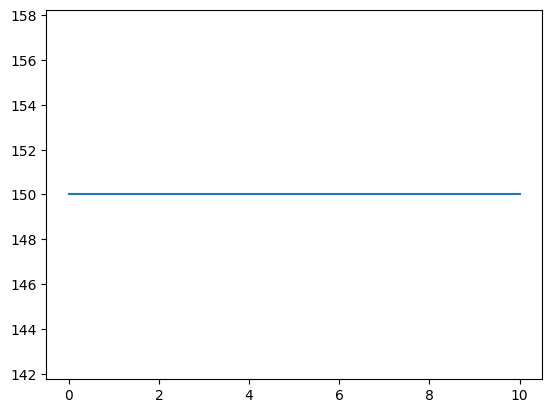

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


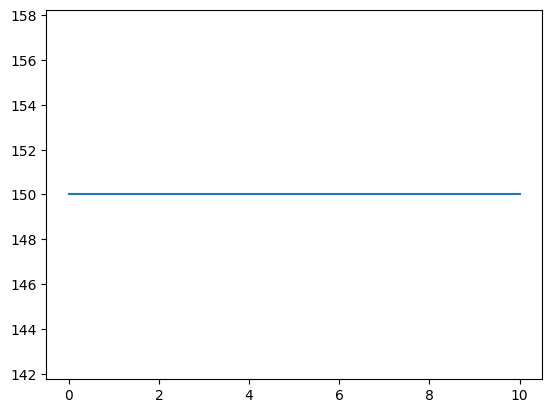

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


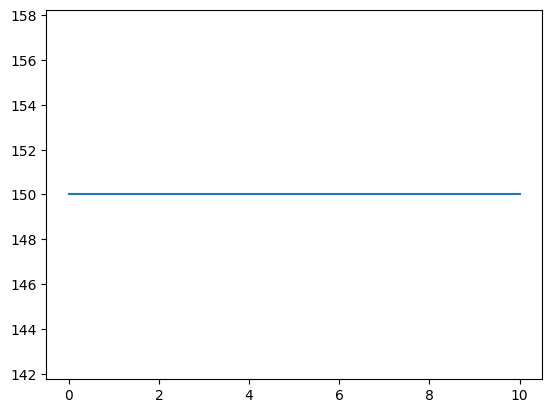

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


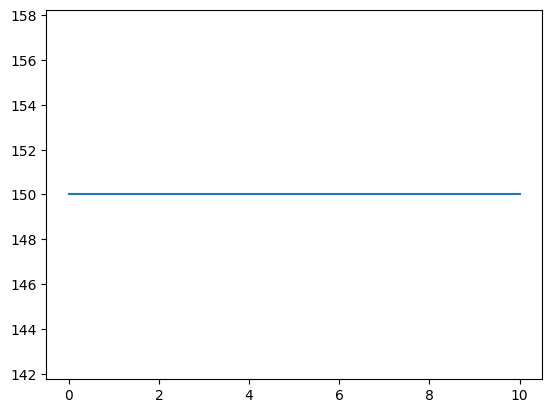

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


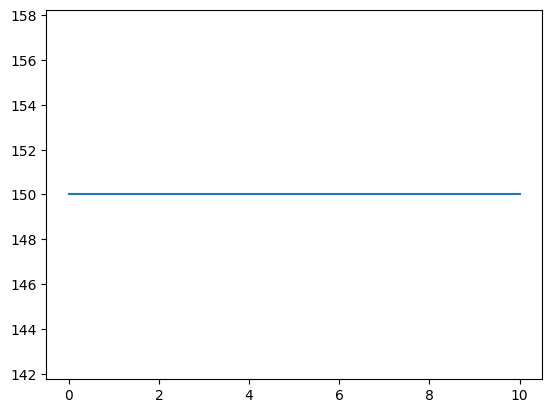

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


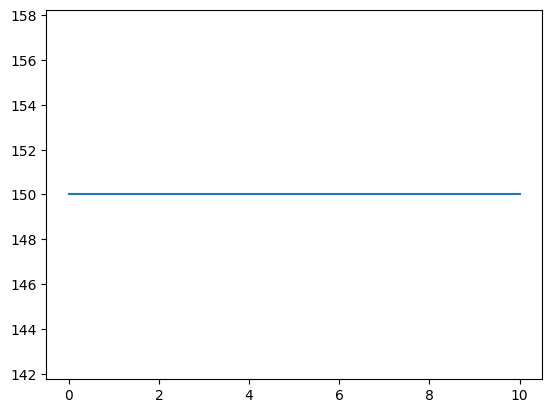

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


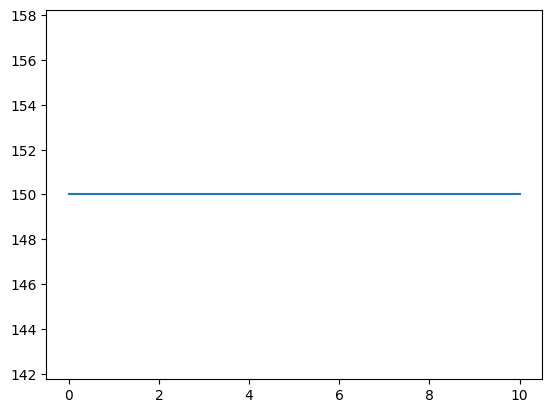

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


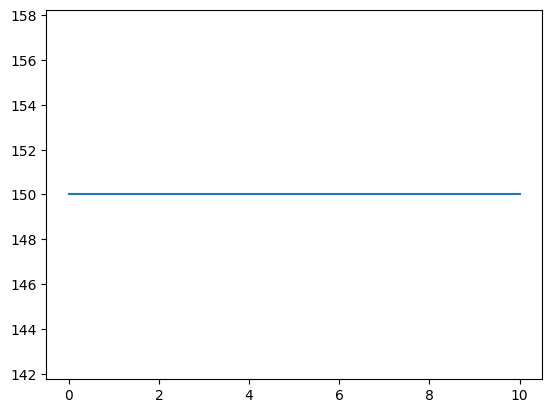

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


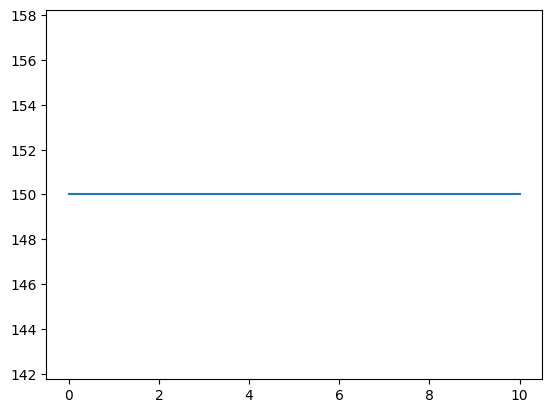

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


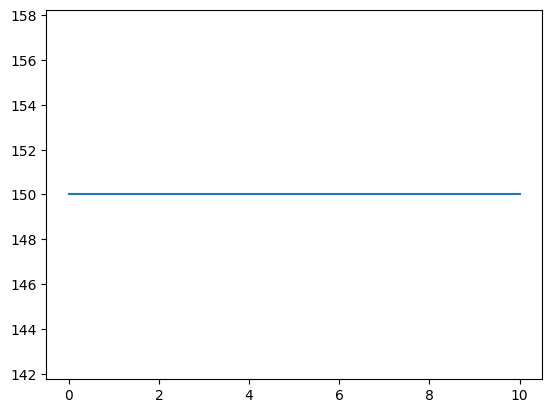

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


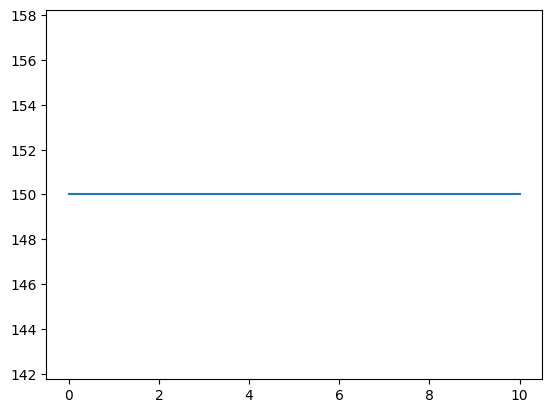

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


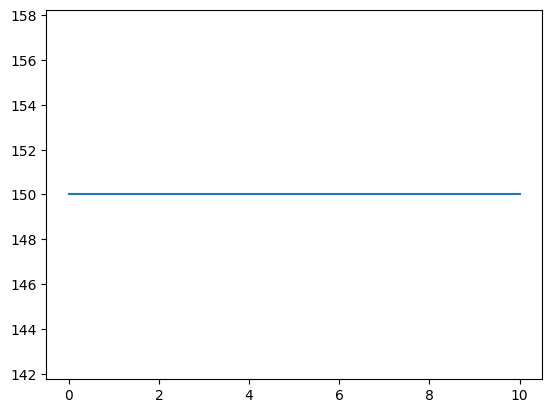

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


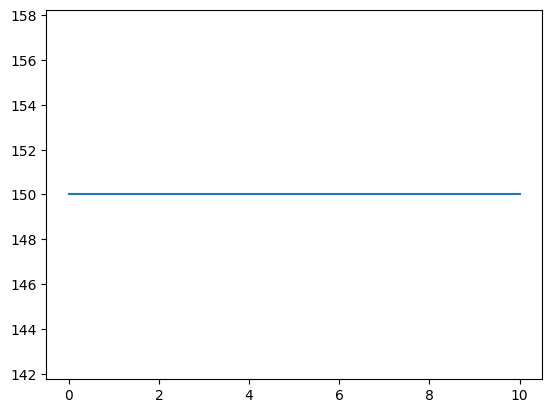

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


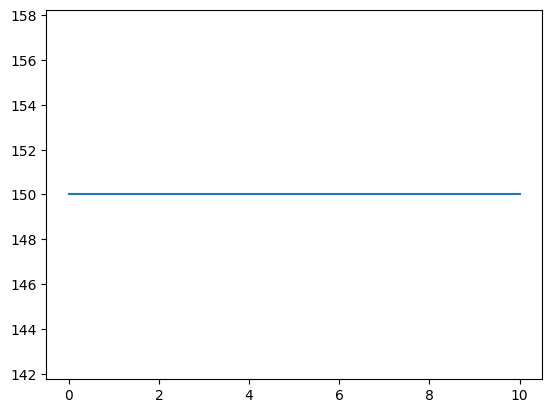

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


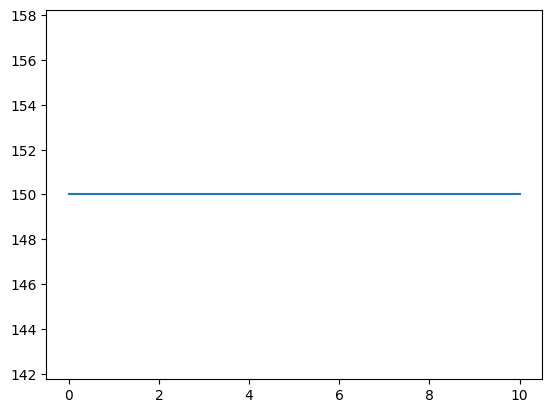

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


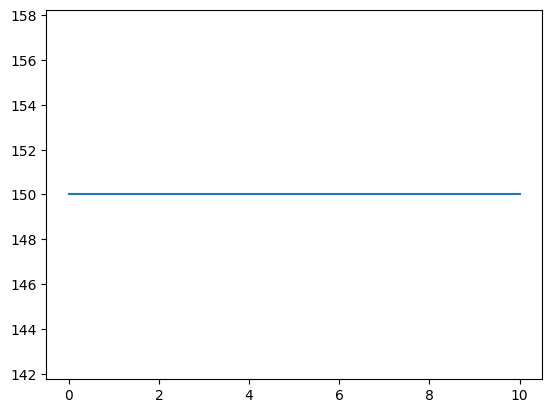

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


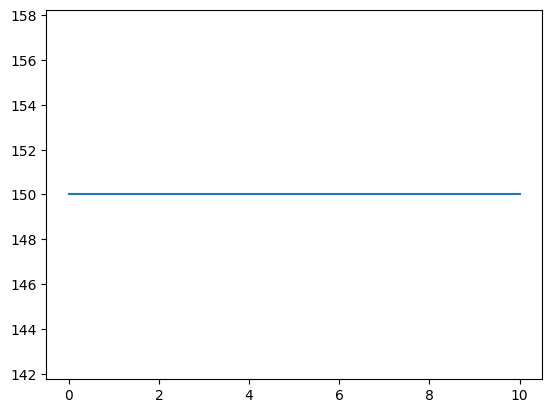

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


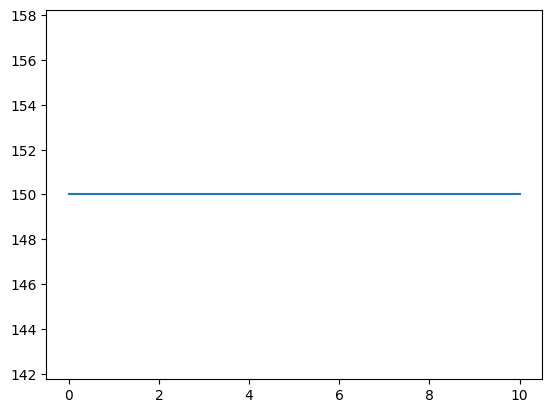

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


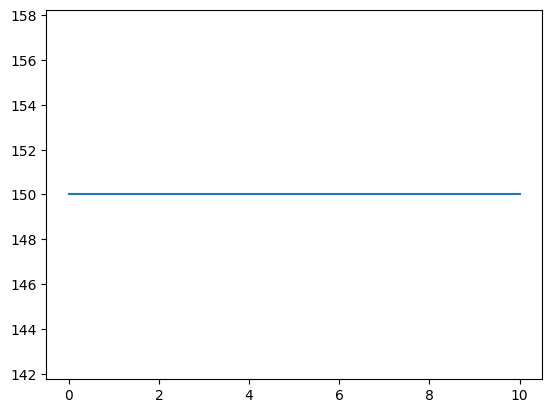

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


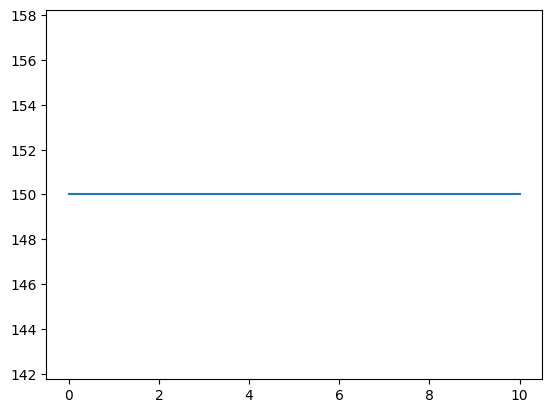

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


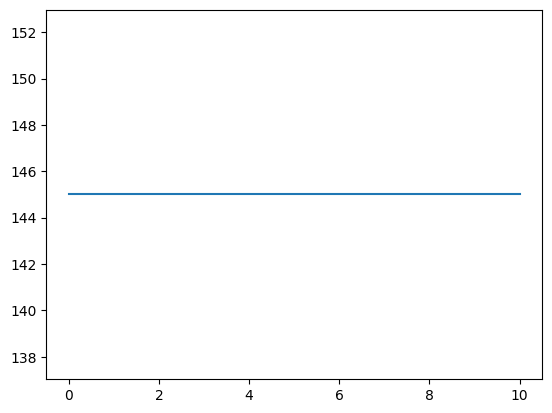

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


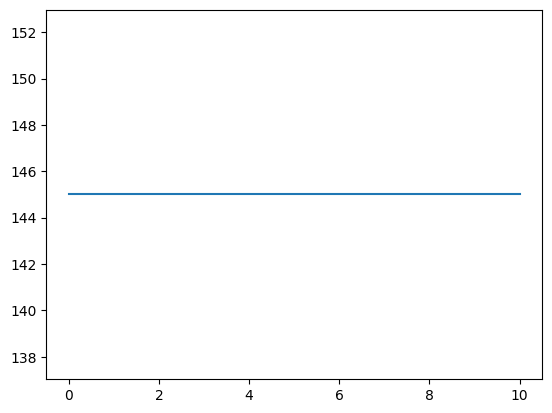

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


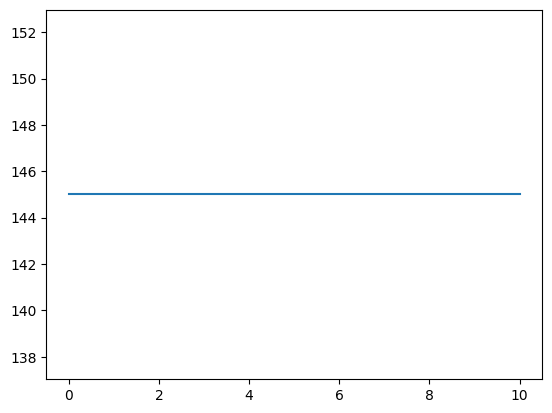

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


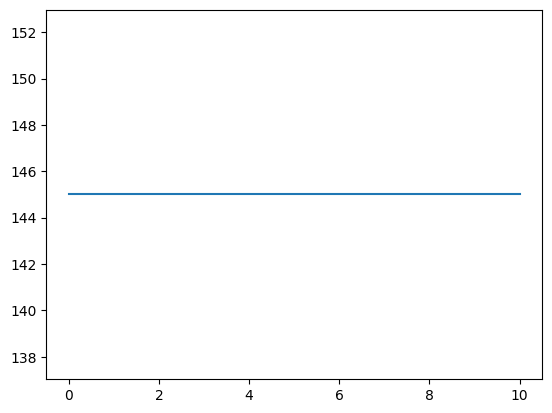

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


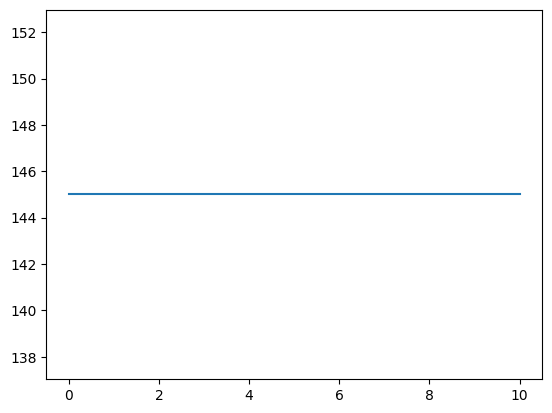

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


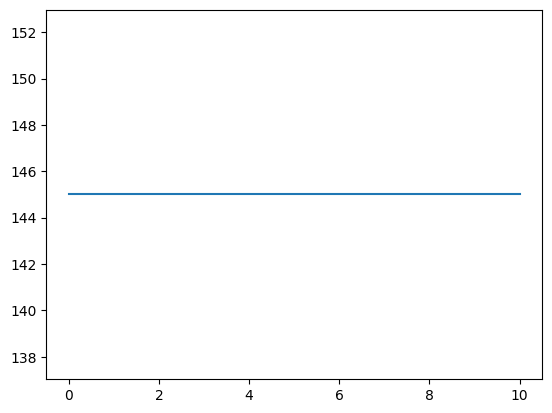

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


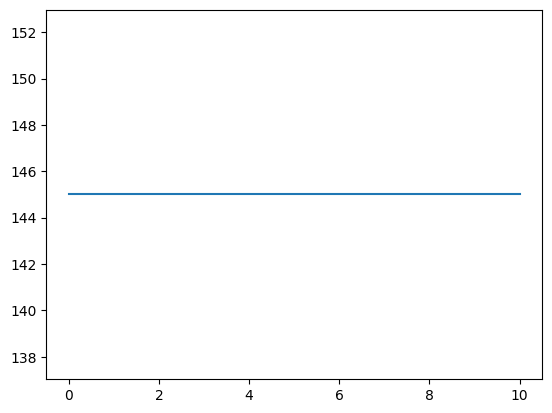

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


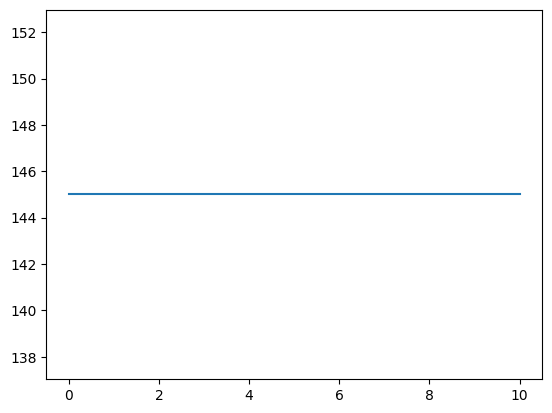

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


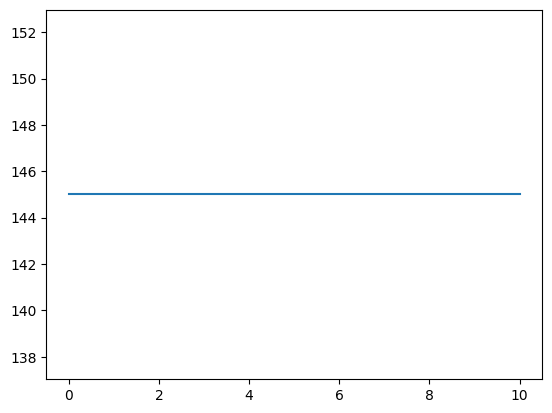

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


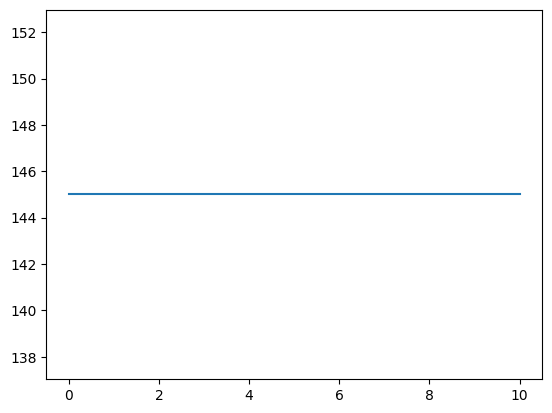

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


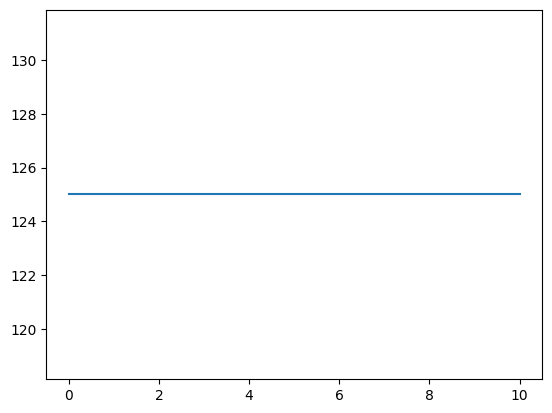

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


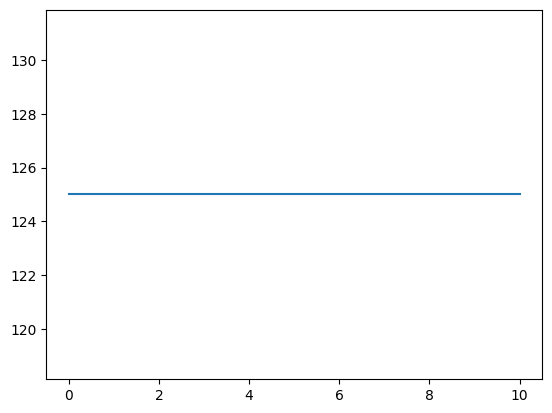

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


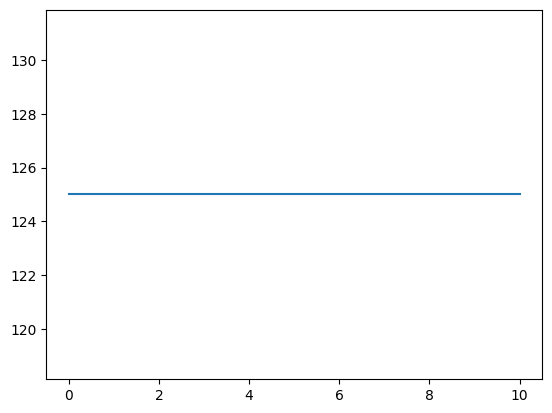

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


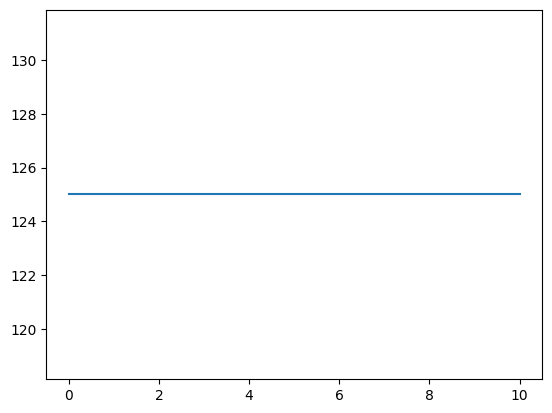

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


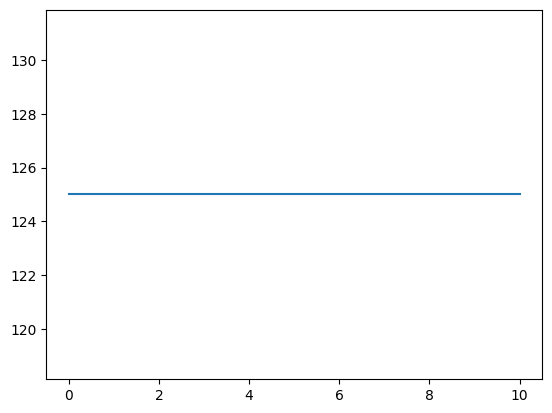

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


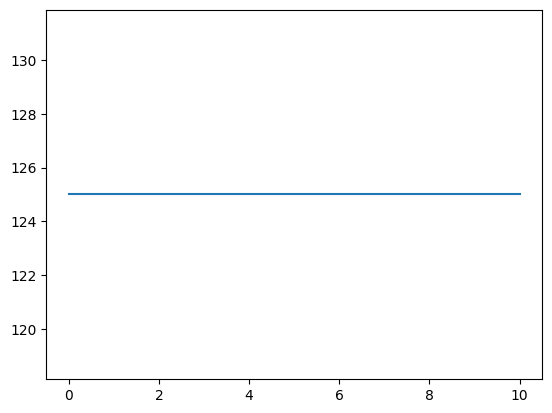

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


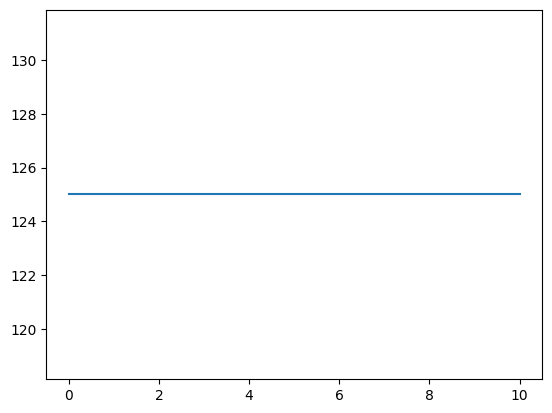

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


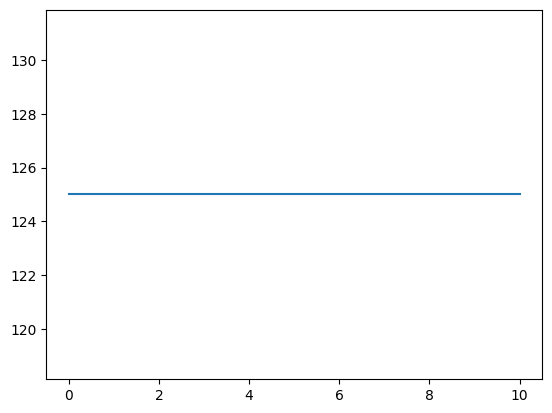

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


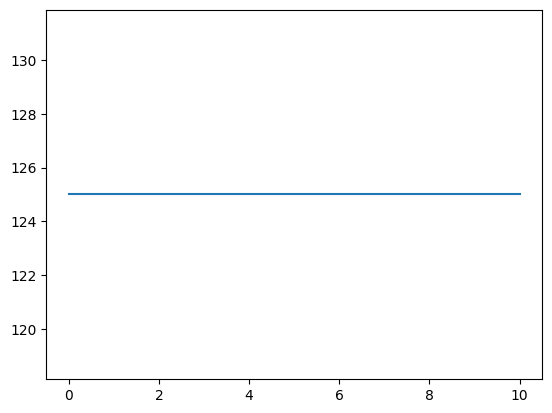

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


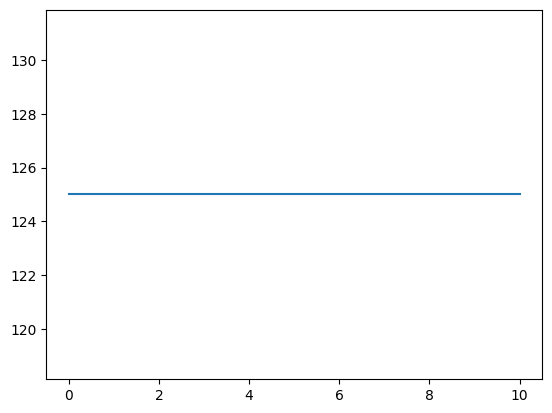

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


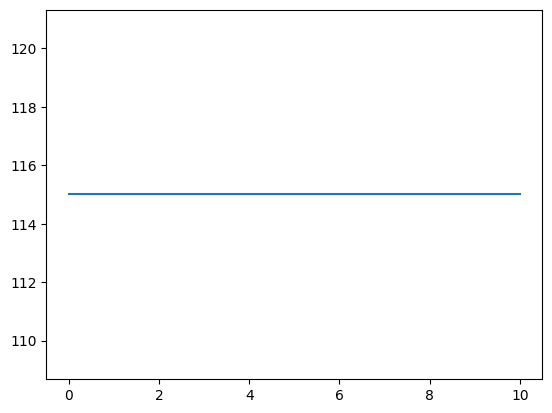

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


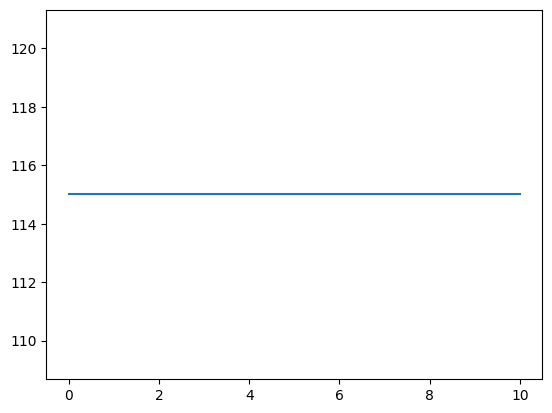

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


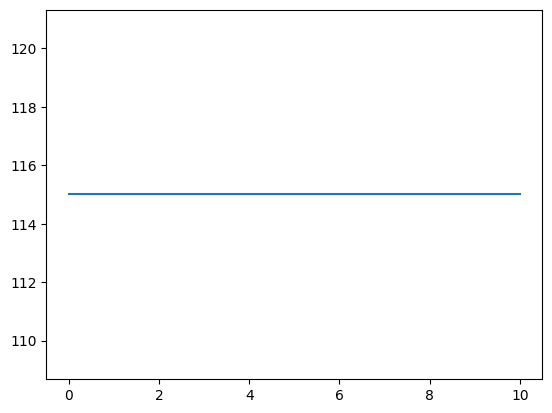

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


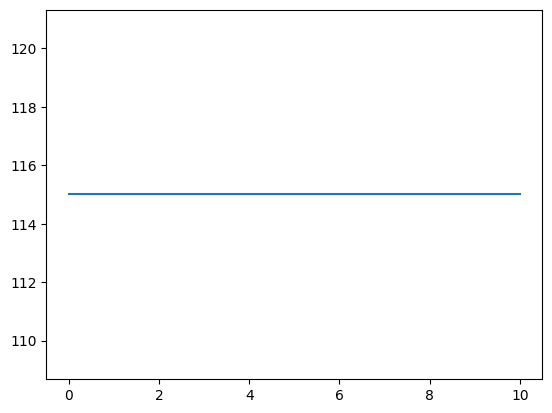

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


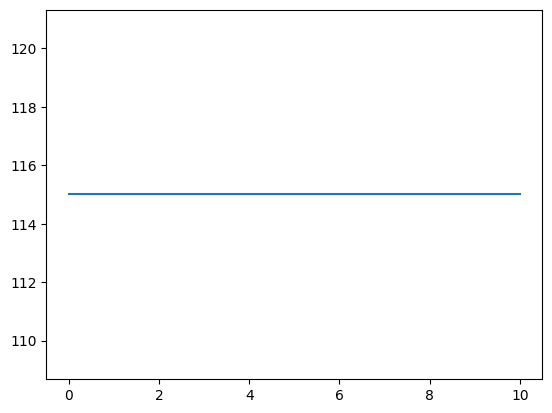

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


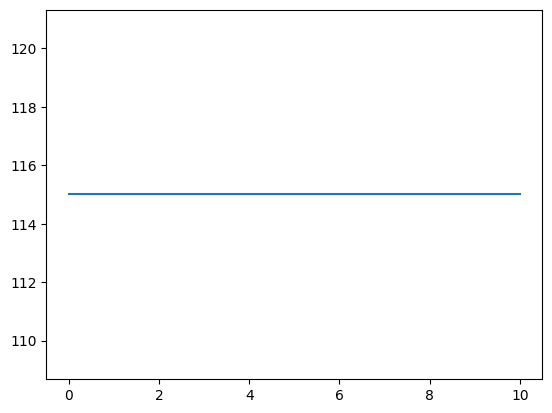

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


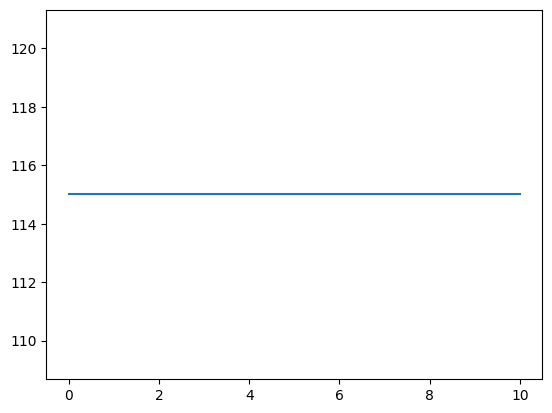

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


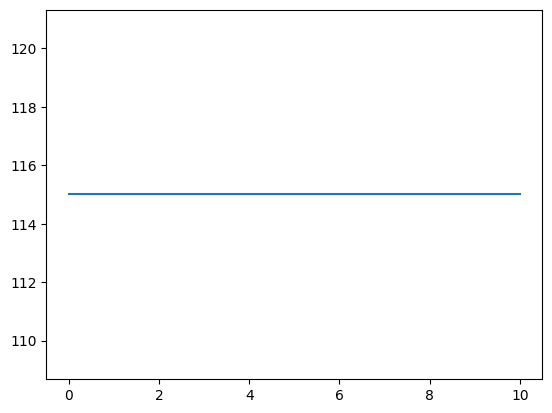

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


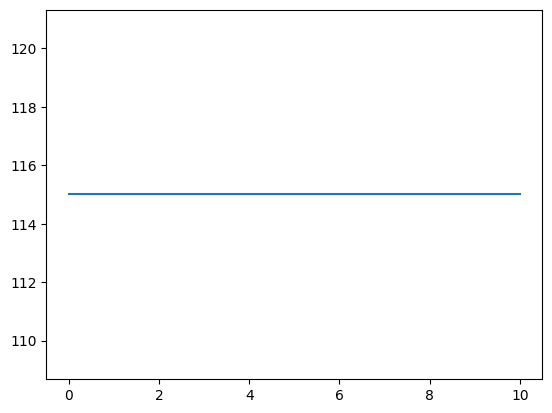

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


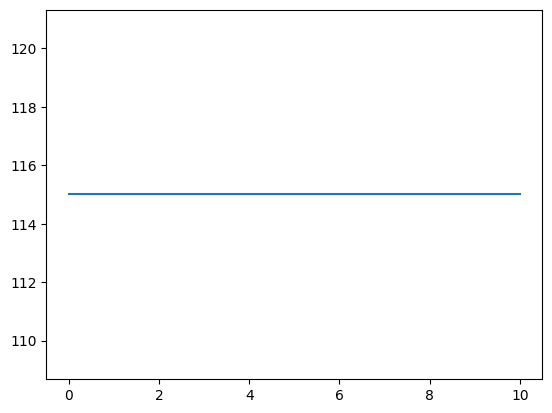

----------------------------------------
maxima posicion:  0
----------------------------------------


In [170]:
## Hiperparametros del algoritmo genetico
ItemPool = [ Item(Random_items[x]) for x in range (0,NUM_ITEMS) ]
MAX_WEIGHT = 15*len(ItemPool)    # maximo peso que puede soportar cada BIN

POPSIZE = 50       # numero de individuos
GENERATIONS = 10   # numero de generaciones
PMUT = 0       # taza de mutacion
NUM_BINS=5

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)
Items_guardados_bin=[]      #Almacenar el valor de los pesos de cada BIN
Elementos_no_elegidos=[]    #Almacenar los pesos que no fueron colocados en ningun BIN al culminar el proceso

mean_first_generation=[]
mode_first_generation=[]


for j in range(NUM_BINS):
  for i in range(10):
    best_ind, bestfitness, index_fitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, PMUT, 
                                              crossover="onepoint", mutation="flip", 
                                              selection_parents_method = 'roulette', 
                                              selection_survivors_method = 'ranking')

    
    plt.plot(bestfitness)
    plt.show()

    max_pos=0
    max_valor=0

    for k in range(len(bestfitness)):
      if bestfitness[k]>max_valor:
        max_valor=bestfitness[k]
        max_pos=k

    array_first_generation_max.append(max_pos)
    print("-"*40)
    print("maxima posicion:  " + str(max_pos))
    print("-"*40)
  mean=statistics.mean(array_first_generation_max)
  moda=statistics.mode(array_first_generation_max)

  mean_first_generation.append(mean)
  mode_first_generation.append(moda)



  #Guardar items de cada BIN
  Item_en_bin=[]
  

  for z in range(len(ItemPool)):
    if index_fitness[z]==1:
      Item_en_bin.append(ItemPool[z])

  Items_guardados_bin.append(Item_en_bin)

  #Actualiza los items faltantes y la poblacion nueva
  Aux_item_pool=ItemPool
  ItemPool=[]
  for q in range(len(Aux_item_pool)):
    if index_fitness[q]==0:
      ItemPool.append(Aux_item_pool[q])

  poblacion_inicial =  init_population(POPSIZE, len(ItemPool))

  if j==(NUM_BINS-1):
    for p in range(len(Aux_item_pool)):
      if index_fitness[p]==0:
        Elementos_no_elegidos.append(Aux_item_pool[p])


In [171]:
mean_first_generation

[0, 0, 0, 0, 0]

In [172]:
mode_first_generation

[0, 0, 0, 0, 0]

In [173]:
Area_total_no_usada=0

print("Metodo de cruzamiento onepoint y tasa de mutacion 0")

for k in range(len(Items_guardados_bin)):
  Area_usada=0
  print("Para el bin numero {}".format(k+1))
  for i in range(len(Items_guardados_bin[k])):
    print("  peso: " + str(Items_guardados_bin[k][i].weight))
    Area_usada+=Items_guardados_bin[k][i].weight
    
  print("Area no usada: " + str(150-Area_usada) + "\n"+"-"*40)
  Area_total_no_usada+=(150-Area_usada)

print("Area total no usada: " + str(Area_total_no_usada))

Metodo de cruzamiento onepoint y tasa de mutacion 0
Para el bin numero 1
  peso: 50
  peso: 100
Area no usada: 0
----------------------------------------
Para el bin numero 2
  peso: 80
  peso: 70
Area no usada: 0
----------------------------------------
Para el bin numero 3
  peso: 60
  peso: 85
Area no usada: 5
----------------------------------------
Para el bin numero 4
  peso: 125
Area no usada: 25
----------------------------------------
Para el bin numero 5
  peso: 115
Area no usada: 35
----------------------------------------
Area total no usada: 65


In [152]:
print("Pesos no elegidos: ")

for i in range(len(Elementos_no_elegidos)):
  print("  peso: " + str(Elementos_no_elegidos[i].weight))

Pesos no elegidos: 
  peso: 110
  peso: 95


#Aqui se emplea el algoritmo genetico cambiando la tasa de mutacion y el operador de cruzamiento uniforme

Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


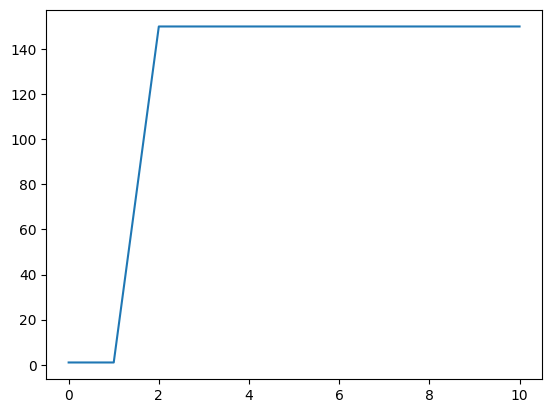

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1] (fitness = 150)


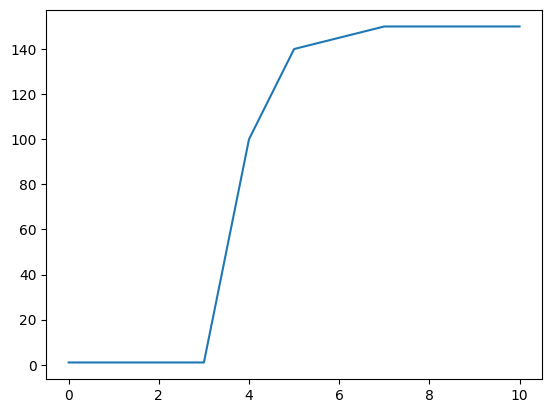

----------------------------------------
maxima posicion:  7
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


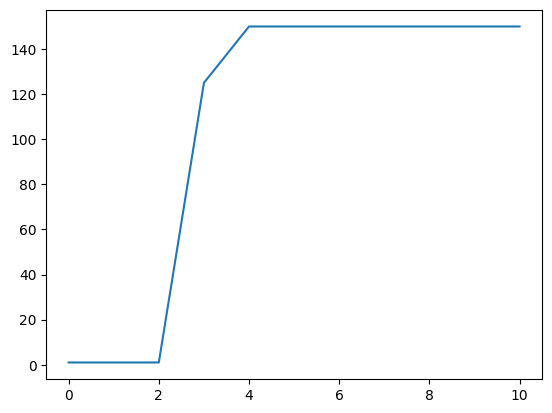

----------------------------------------
maxima posicion:  4
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 95)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


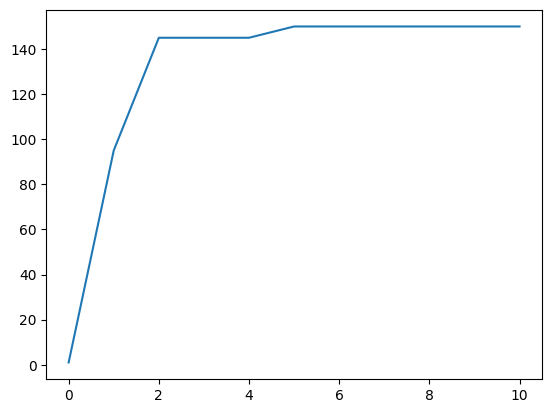

----------------------------------------
maxima posicion:  5
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


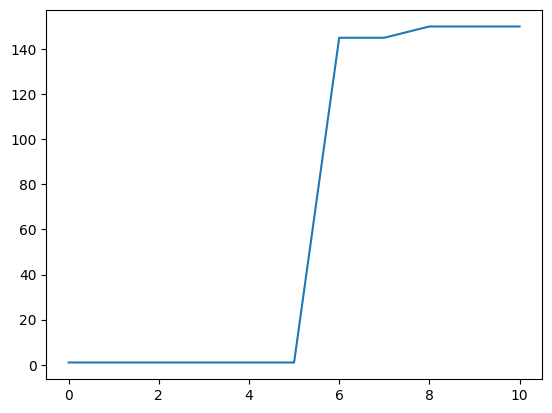

----------------------------------------
maxima posicion:  8
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1] (fitness = 150)


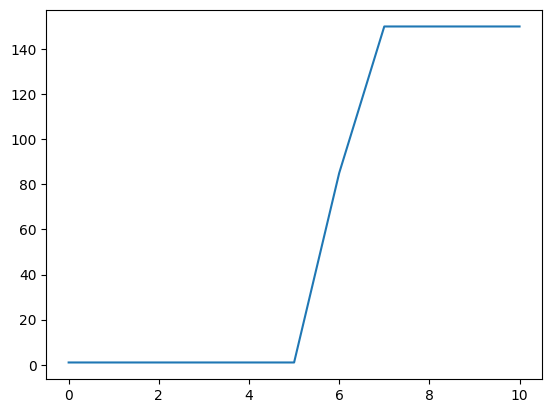

----------------------------------------
maxima posicion:  7
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1] (fitness = 150)


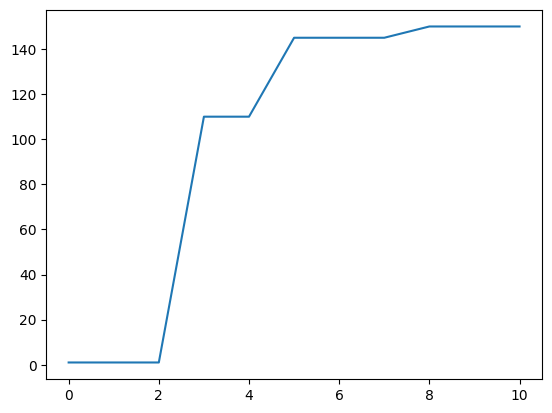

----------------------------------------
maxima posicion:  8
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] (fitness = 145)


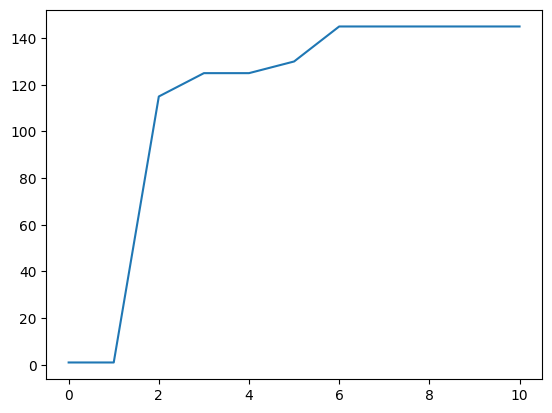

----------------------------------------
maxima posicion:  6
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 85)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1] (fitness = 150)


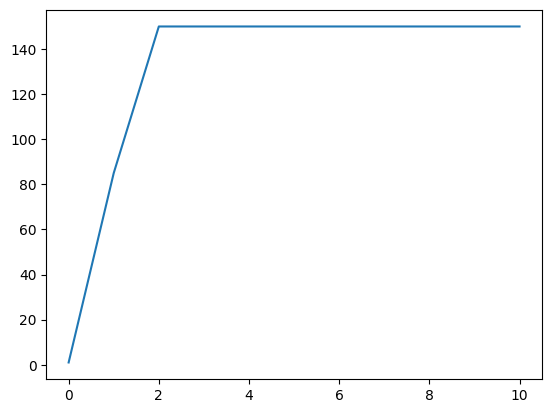

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 1
generacion 0, (Mejor fitness = 1)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


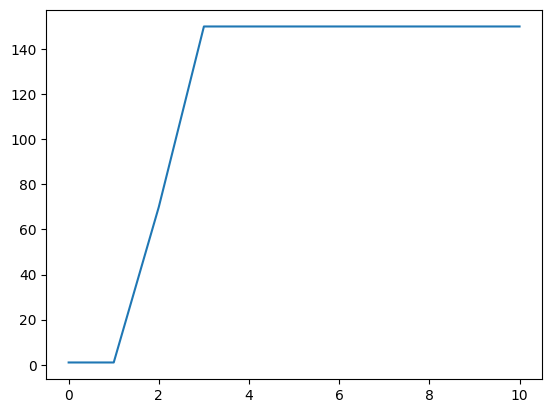

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


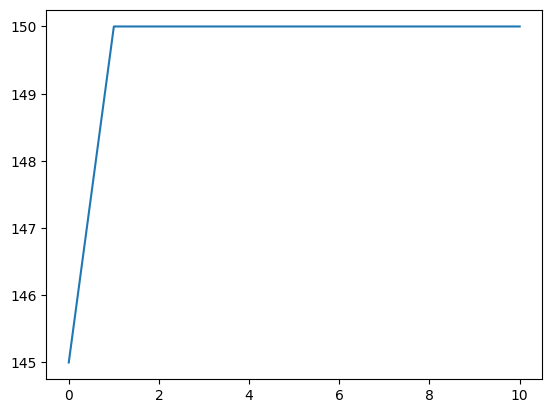

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0, 0, 0] (fitness = 145)


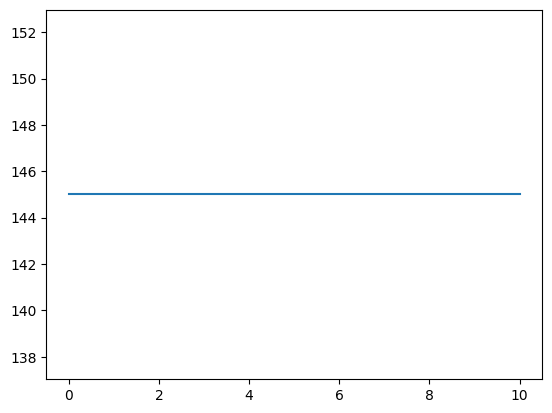

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0, 0, 0] (fitness = 145)


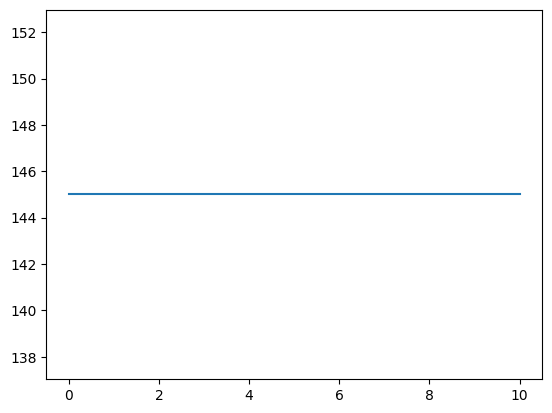

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


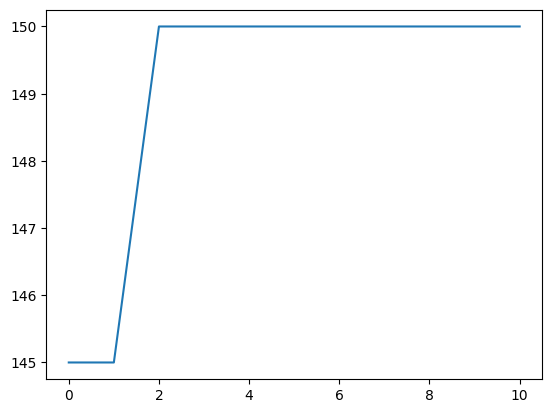

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


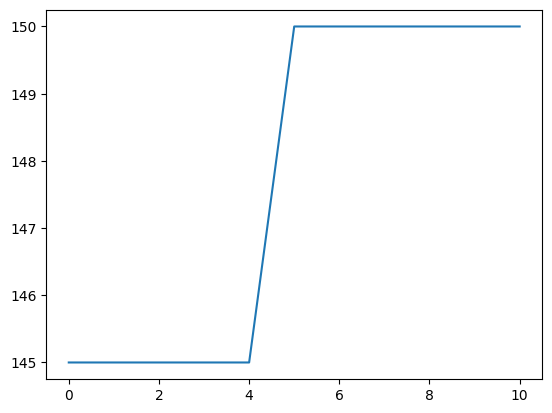

----------------------------------------
maxima posicion:  5
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0, 0, 0] (fitness = 145)


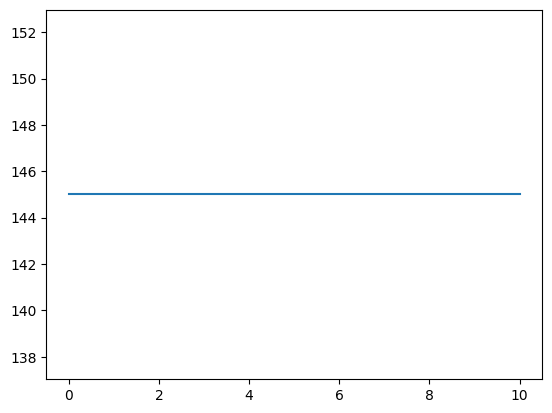

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


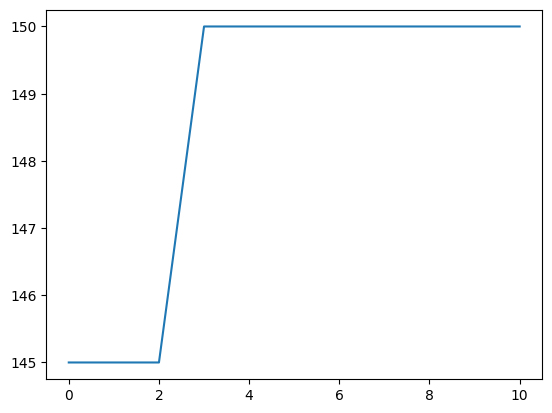

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0, 0, 0] (fitness = 145)


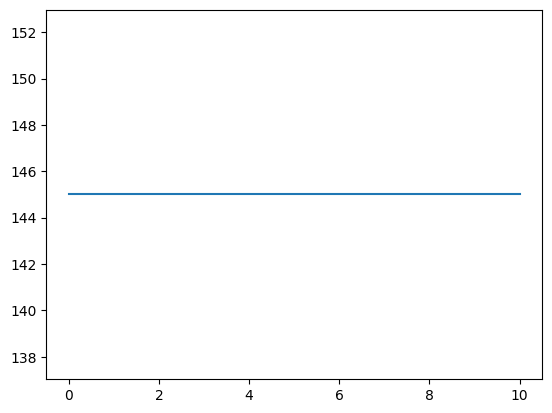

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


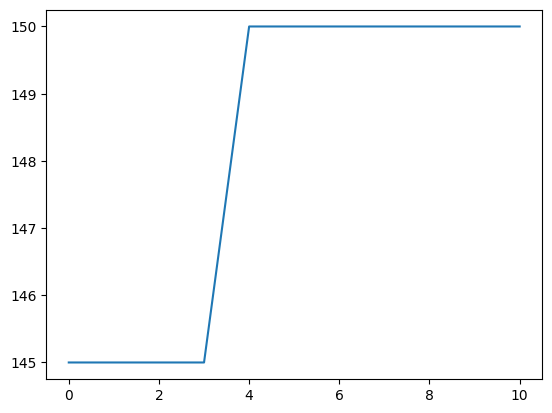

----------------------------------------
maxima posicion:  4
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0, 0, 0] (fitness = 145)


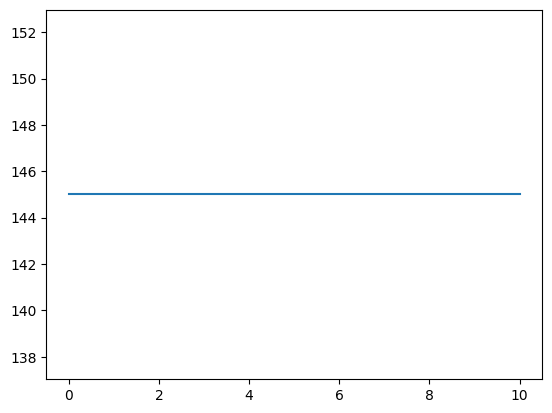

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


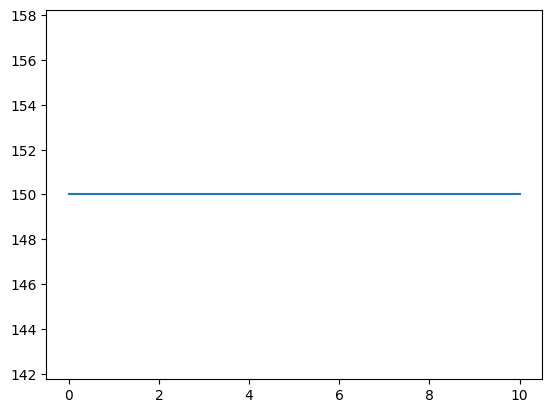

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


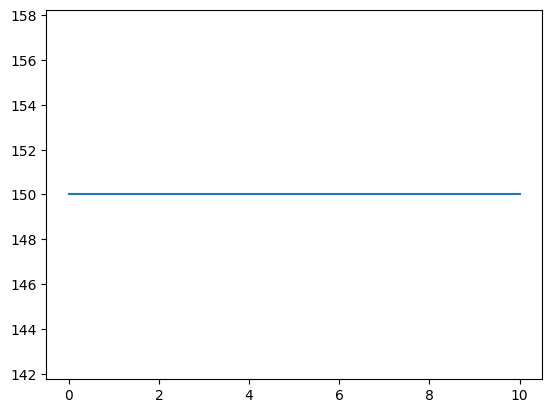

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


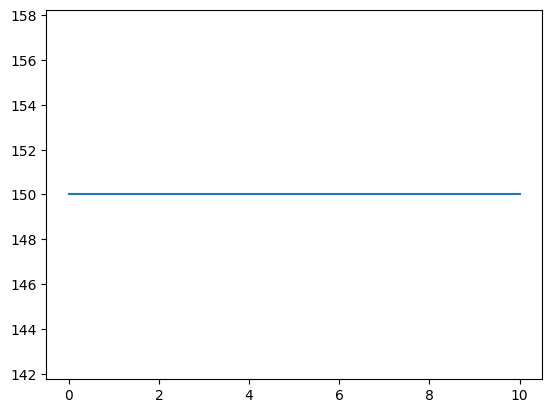

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


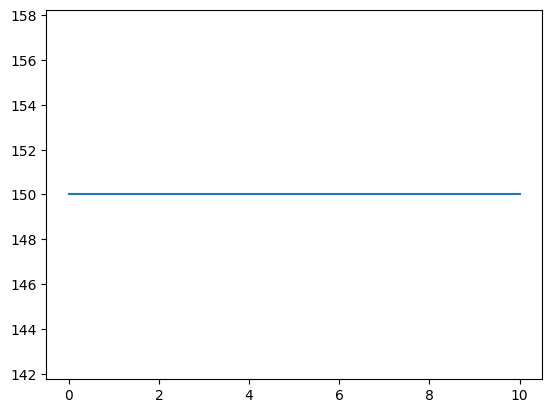

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


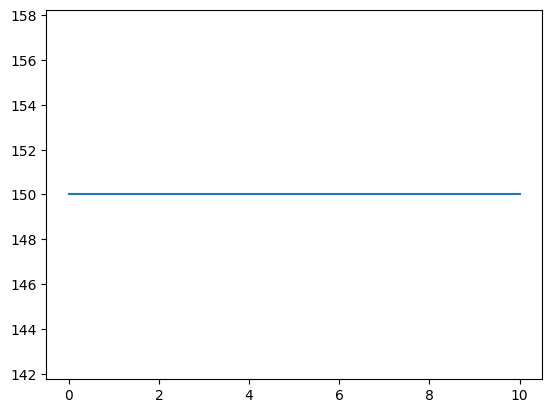

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


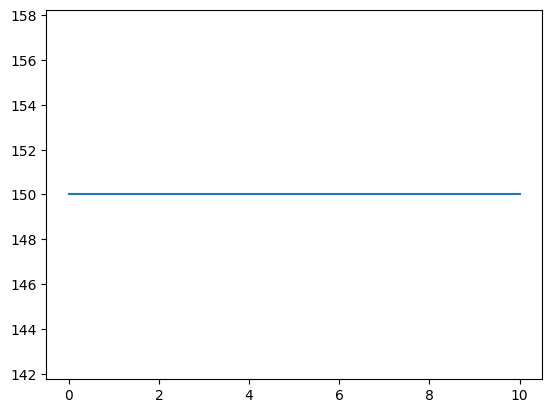

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


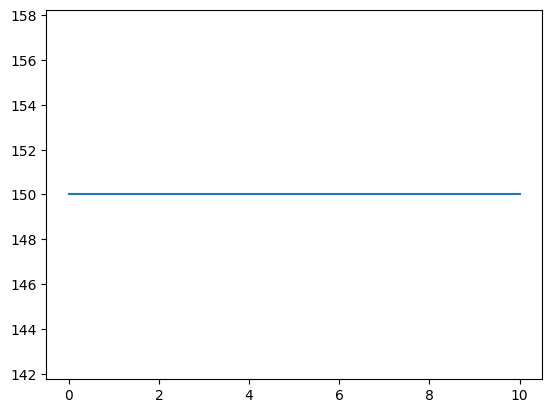

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


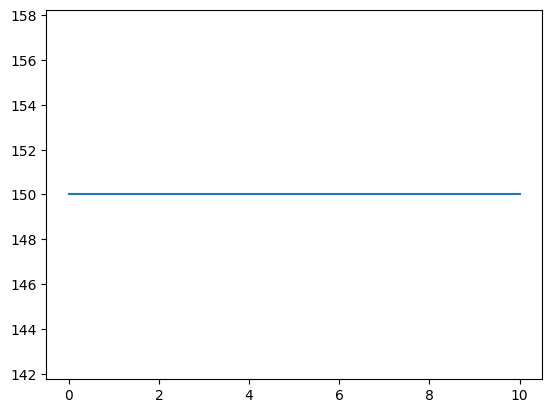

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


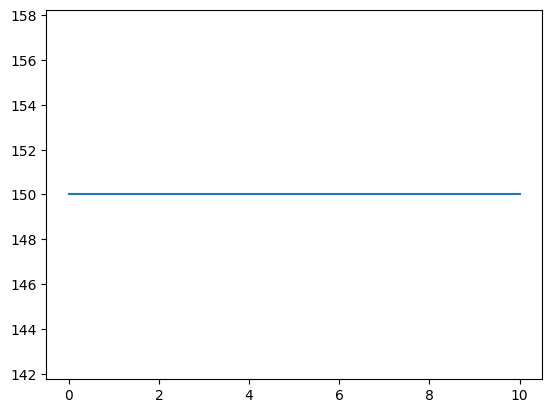

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 150
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 1, 0, 1] (fitness = 150)


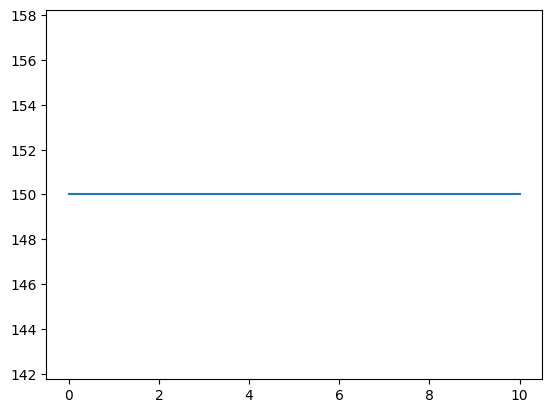

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


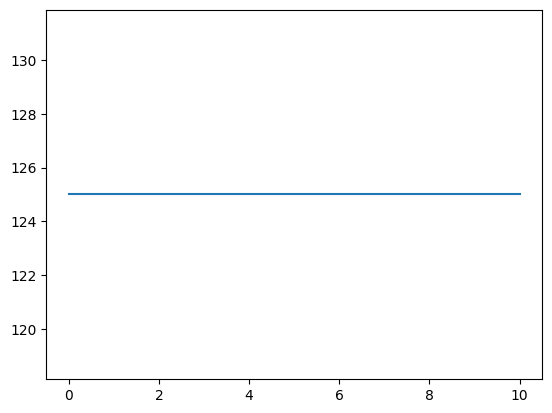

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


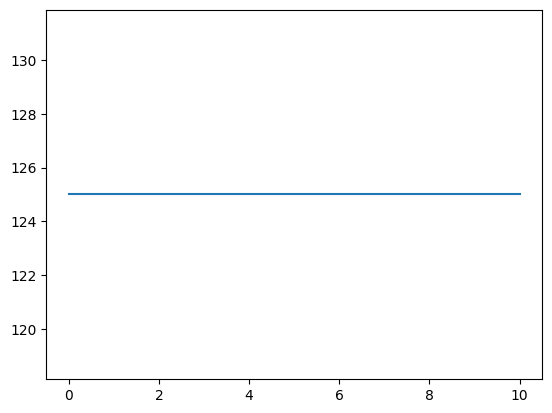

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


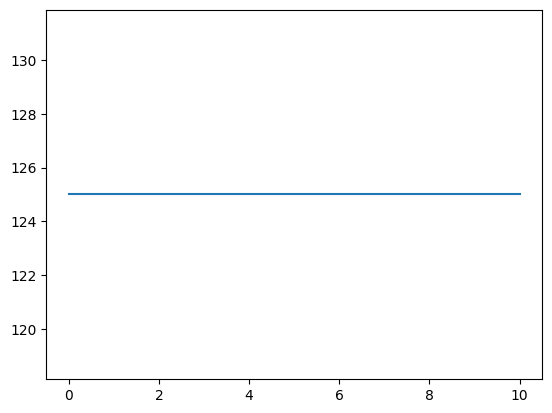

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


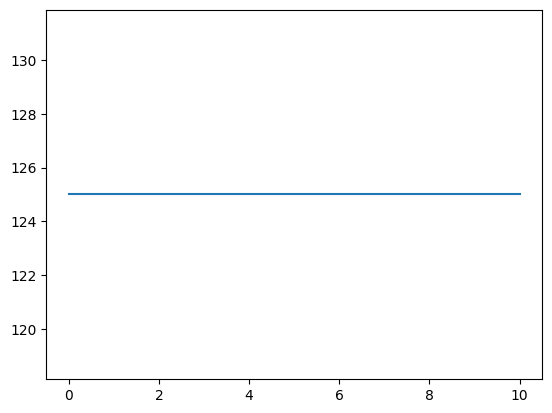

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


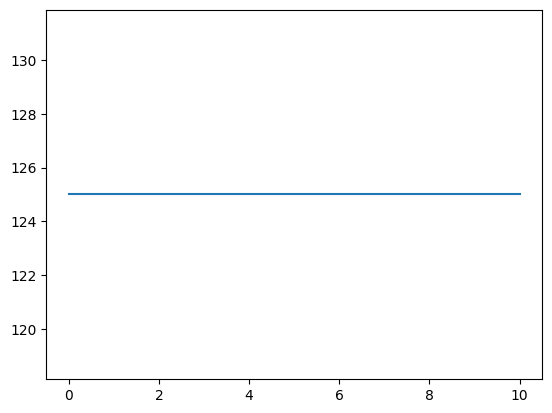

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


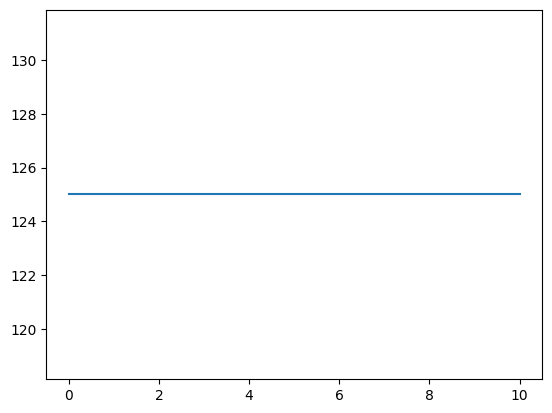

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


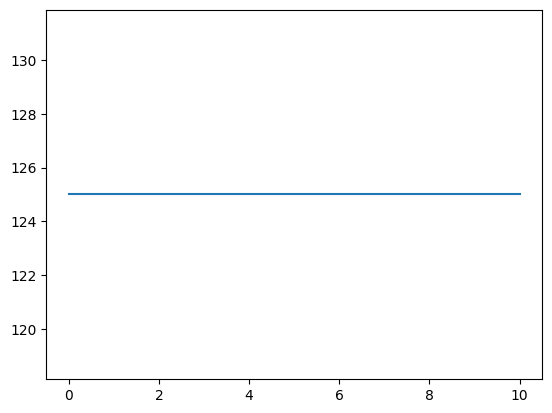

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


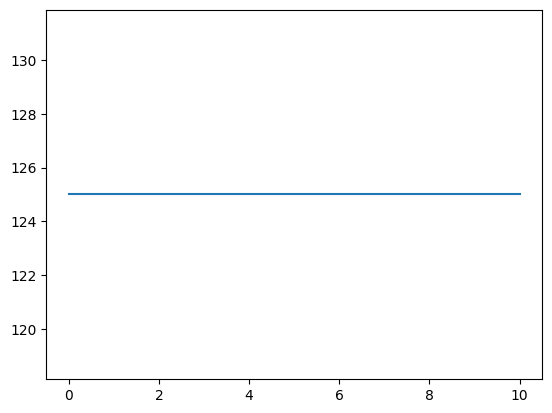

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


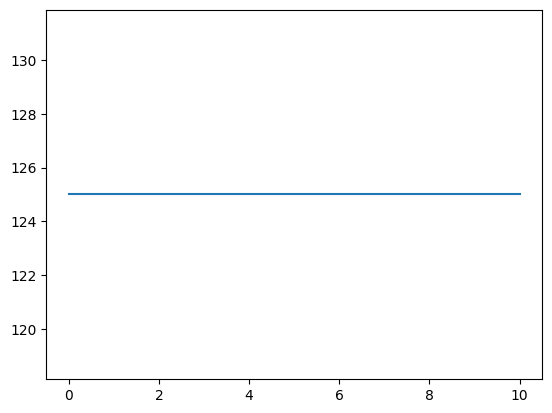

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


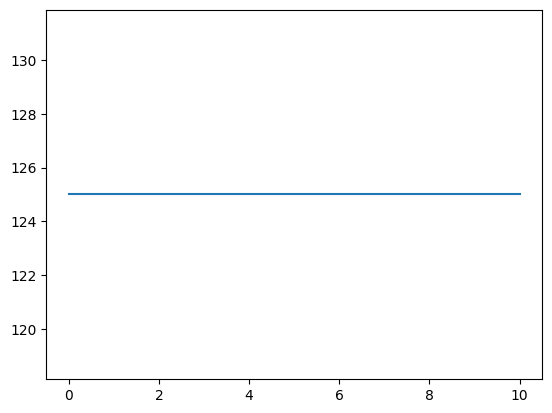

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


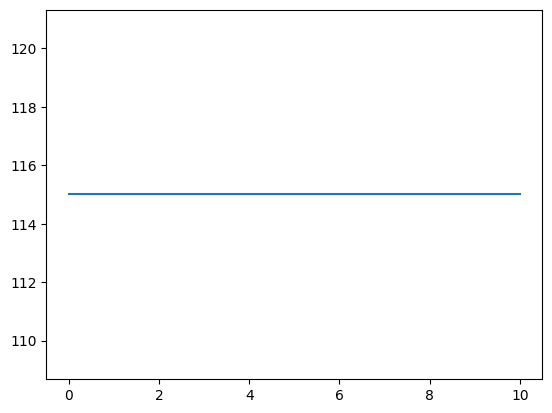

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


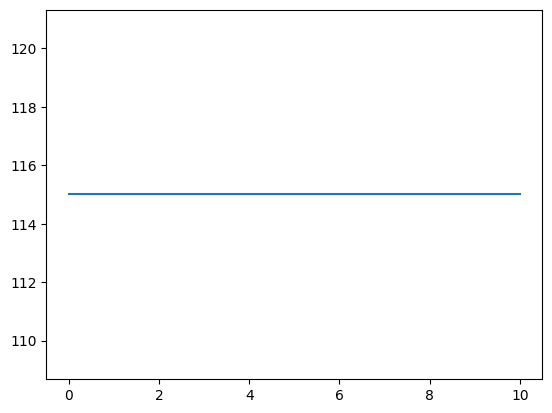

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


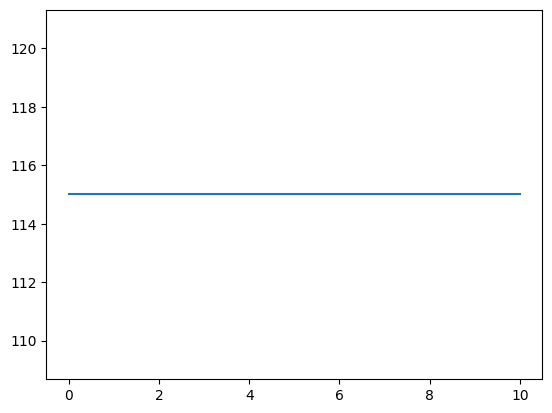

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


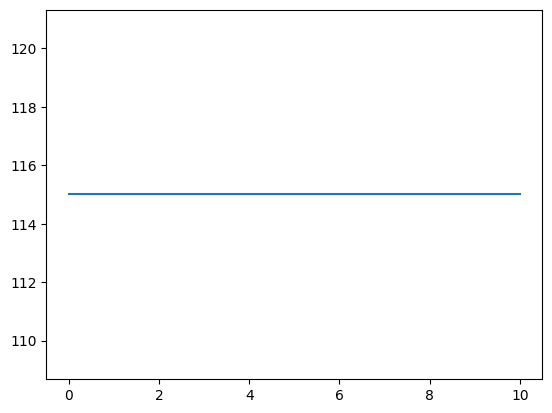

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


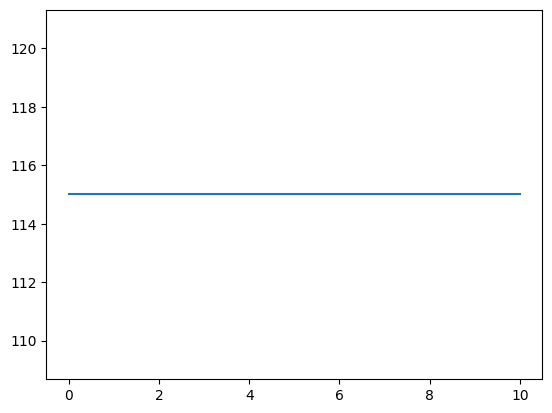

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


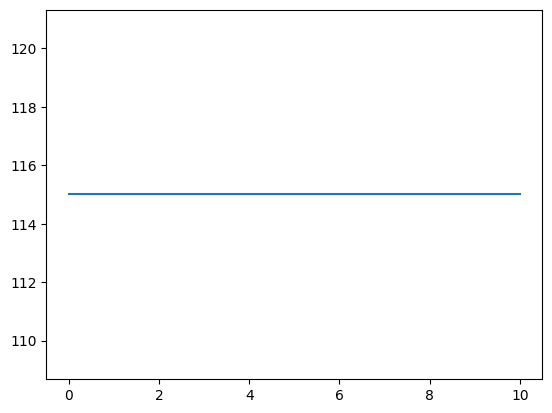

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


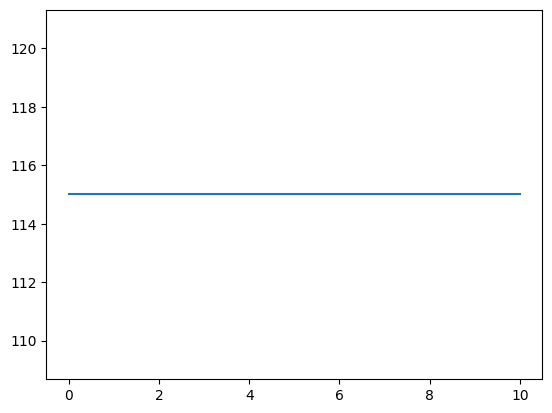

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


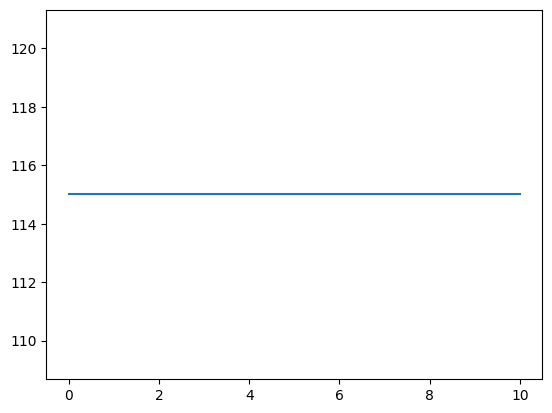

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


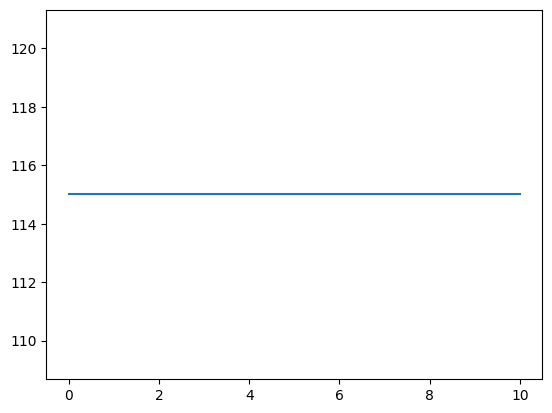

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


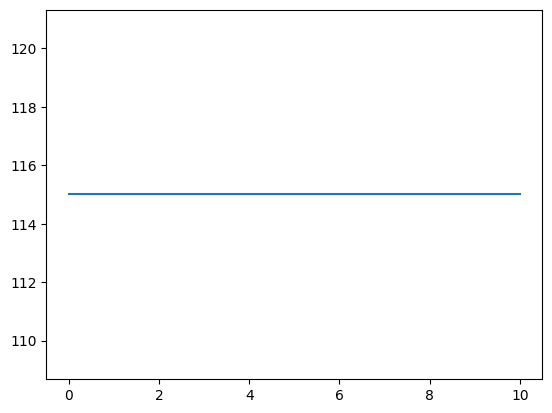

----------------------------------------
maxima posicion:  0
----------------------------------------


In [174]:
## Hiperparametros del algoritmo genetico
ItemPool = [ Item(Random_items[x]) for x in range (0,NUM_ITEMS) ]
MAX_WEIGHT = 15*len(ItemPool)    # maximo peso que puede soportar cada BIN

POPSIZE = 50       # numero de individuos
GENERATIONS = 10   # numero de generaciones
PMUT = 0.7       # taza de mutacion
NUM_BINS=5

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)
Items_guardados_bin=[]      #Almacenar el valor de los pesos de cada BIN
Elementos_no_elegidos=[]    #Almacenar los pesos que no fueron colocados en ningun BIN al culminar el proceso

mean_first_generation=[]
mode_first_generation=[]

for j in range(NUM_BINS):
  for i in range(10):
    best_ind, bestfitness, index_fitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, PMUT, 
                                              crossover="uniform", mutation="flip", 
                                              selection_parents_method = 'roulette', 
                                              selection_survivors_method = 'ranking')

    
    plt.plot(bestfitness)
    plt.show()

    max_pos=0
    max_valor=0

    for k in range(len(bestfitness)):
      if bestfitness[k]>max_valor:
        max_valor=bestfitness[k]
        max_pos=k

    array_first_generation_max.append(max_pos)
    print("-"*40)
    print("maxima posicion:  " + str(max_pos))
    print("-"*40)
  mean=statistics.mean(array_first_generation_max)
  moda=statistics.mode(array_first_generation_max)

  mean_first_generation.append(mean)
  mode_first_generation.append(moda)


  #Guardar items de cada BIN
  Item_en_bin=[]
  

  for z in range(len(ItemPool)):
    if index_fitness[z]==1:
      Item_en_bin.append(ItemPool[z])

  Items_guardados_bin.append(Item_en_bin)

  #Actualiza los items faltantes y la poblacion nueva
  Aux_item_pool=ItemPool
  ItemPool=[]
  for q in range(len(Aux_item_pool)):
    if index_fitness[q]==0:
      ItemPool.append(Aux_item_pool[q])

  poblacion_inicial =  init_population(POPSIZE, len(ItemPool))

  if j==(NUM_BINS-1):
    for p in range(len(Aux_item_pool)):
      if index_fitness[p]==0:
        Elementos_no_elegidos.append(Aux_item_pool[p])

In [175]:
mean_first_generation

[0.7428571428571429, 0.8375, 0.7444444444444445, 0.67, 0.6090909090909091]

In [176]:
mode_first_generation

[0, 0, 0, 0, 0]

In [177]:
Area_total_no_usada=0

print("Metodo de cruzamiento uniforme y tasa de mutacion 0.7")

for k in range(len(Items_guardados_bin)):
  Area_usada=0
  print("Para el bin numero {}".format(k+1))
  for i in range(len(Items_guardados_bin[k])):
    print("  peso: " + str(Items_guardados_bin[k][i].weight))
    Area_usada+=Items_guardados_bin[k][i].weight
    
  print("Area no usada: " + str(150-Area_usada) + "\n"+"-"*40)
  Area_total_no_usada+=(150-Area_usada)

print("Area total no usada: " + str(Area_total_no_usada))

Metodo de cruzamiento uniforme y tasa de mutacion 0.7
Para el bin numero 1
  peso: 50
  peso: 100
Area no usada: 0
----------------------------------------
Para el bin numero 2
  peso: 60
  peso: 85
Area no usada: 5
----------------------------------------
Para el bin numero 3
  peso: 80
  peso: 70
Area no usada: 0
----------------------------------------
Para el bin numero 4
  peso: 125
Area no usada: 25
----------------------------------------
Para el bin numero 5
  peso: 115
Area no usada: 35
----------------------------------------
Area total no usada: 65


In [178]:
print("Pesos no elegidos: ")

for i in range(len(Elementos_no_elegidos)):
  print("  peso: " + str(Elementos_no_elegidos[i].weight))

Pesos no elegidos: 
  peso: 110
  peso: 95


#Aqui se emplea el algoritmo genetico cambiando la tasa de mutacion y el operador de cruzamiento onepoint

Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 0, 1, 0, 0, 1] (fitness = 150)


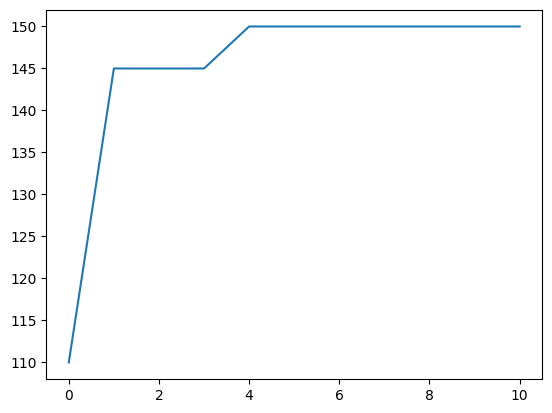

----------------------------------------
maxima posicion:  4
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 0, 1, 0, 0, 0, 0, 0, 0, 0] (fitness = 145)


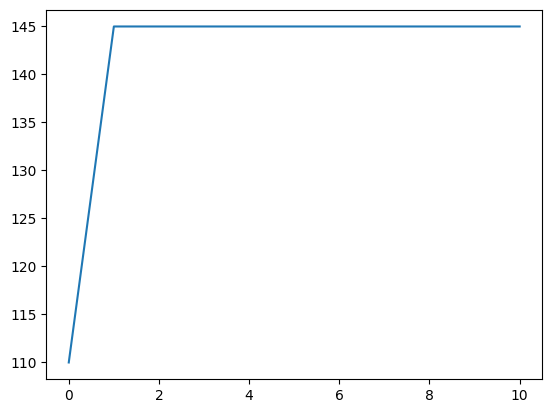

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


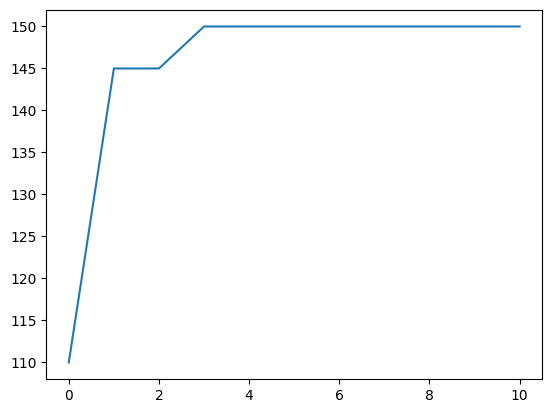

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 135)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


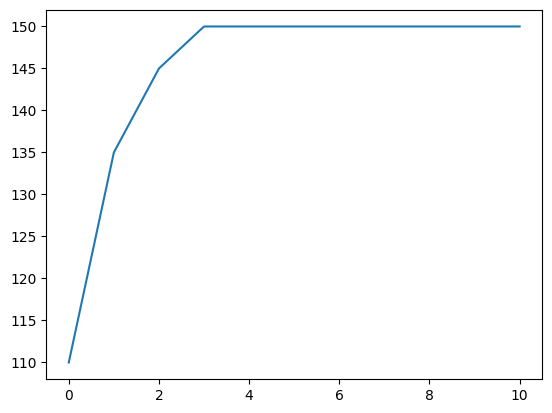

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


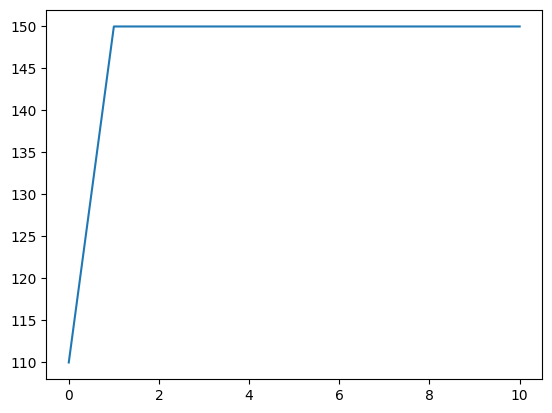

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


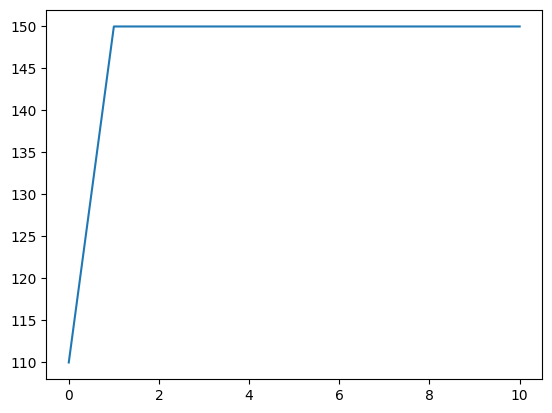

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


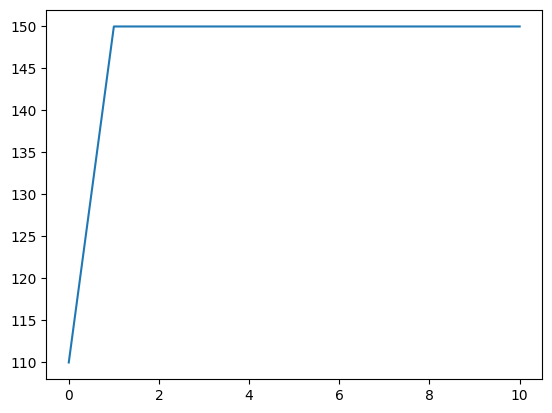

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 120)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


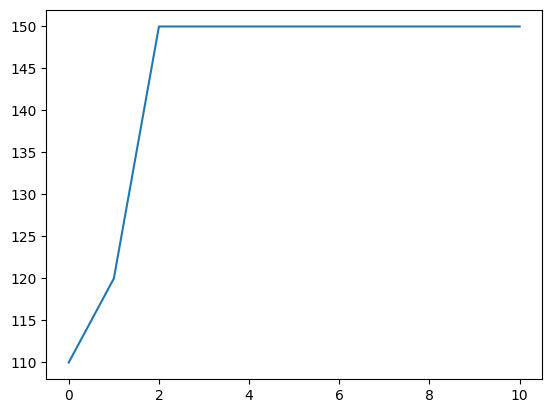

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 110)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


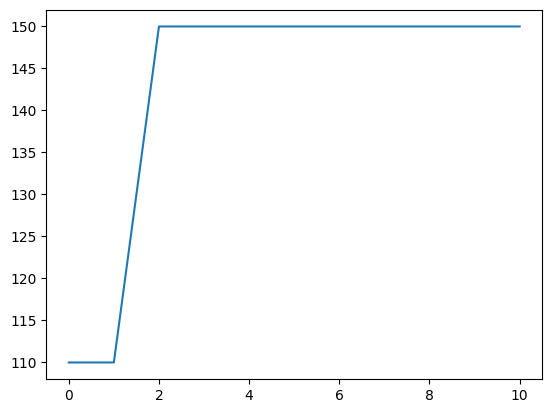

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 110
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 1, 0, 0] (fitness = 150)


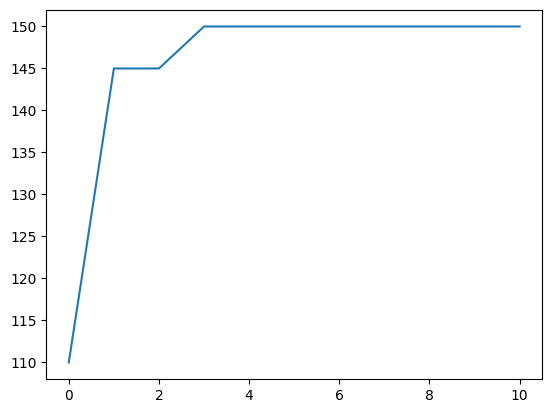

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


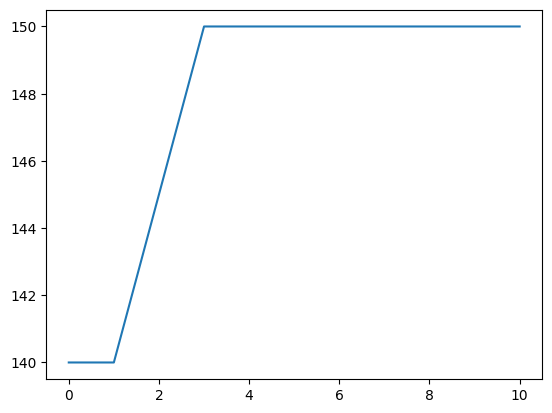

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


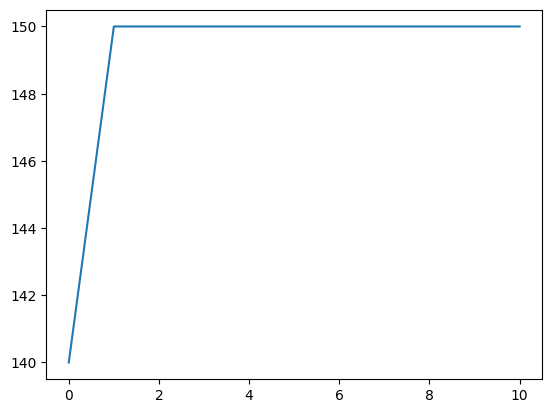

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


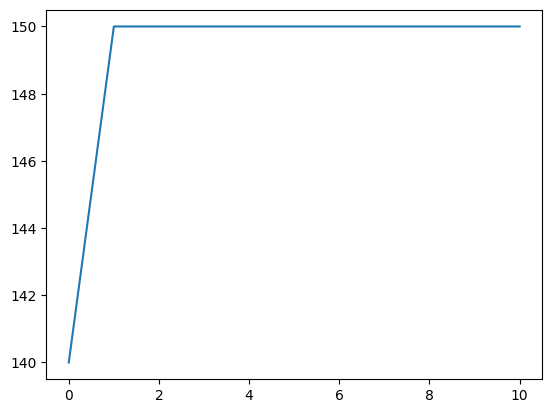

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 150)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


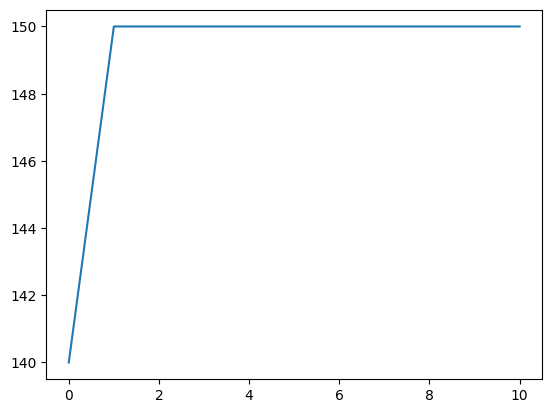

----------------------------------------
maxima posicion:  1
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


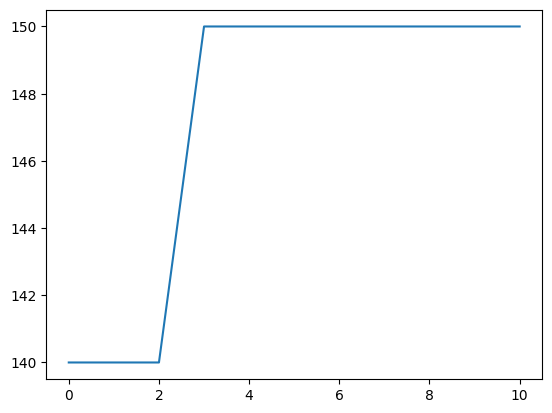

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


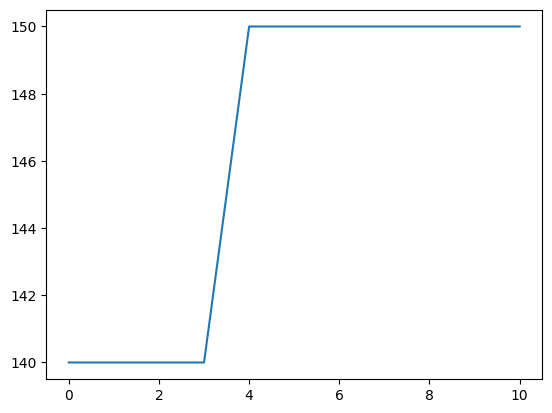

----------------------------------------
maxima posicion:  4
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


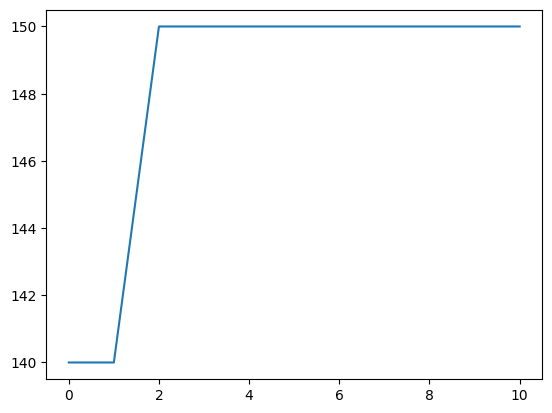

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


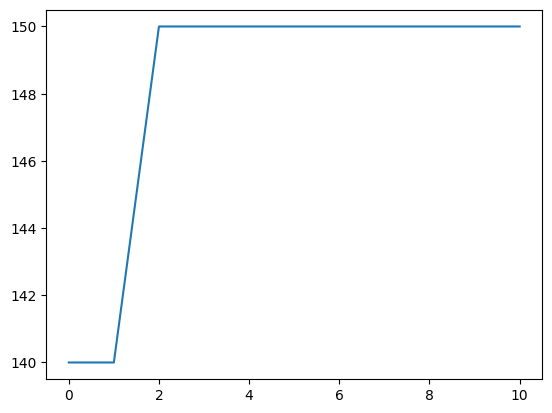

----------------------------------------
maxima posicion:  2
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


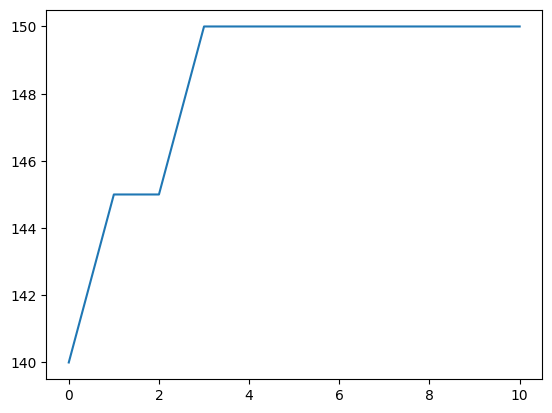

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 140
generacion 0, (Mejor fitness = 140)
Mejor individuo en la ultima generacion = [0, 0, 0, 0, 0, 1, 0, 1] (fitness = 150)


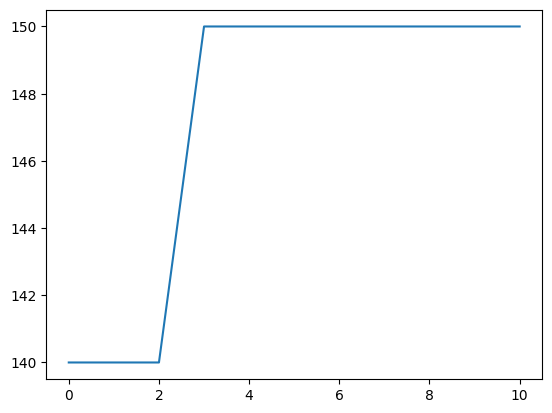

----------------------------------------
maxima posicion:  3
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


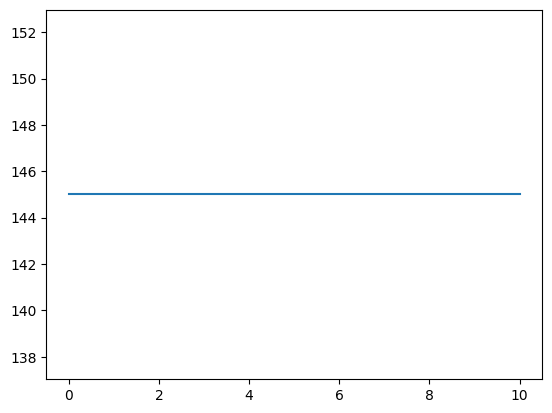

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


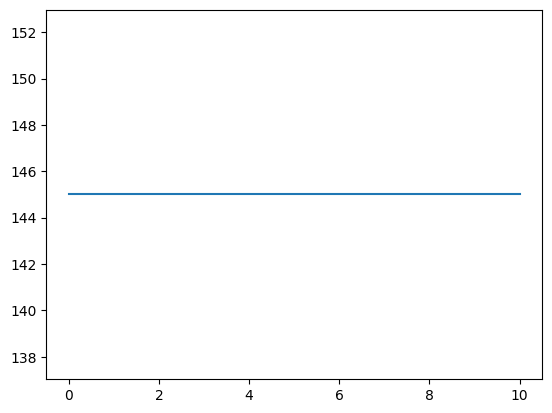

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


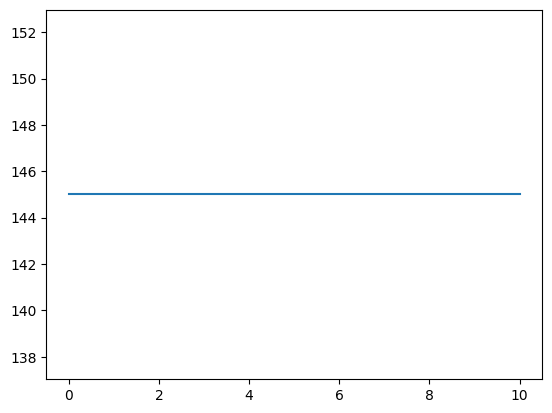

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


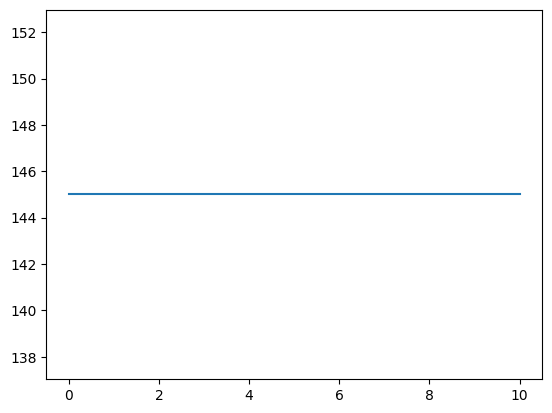

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


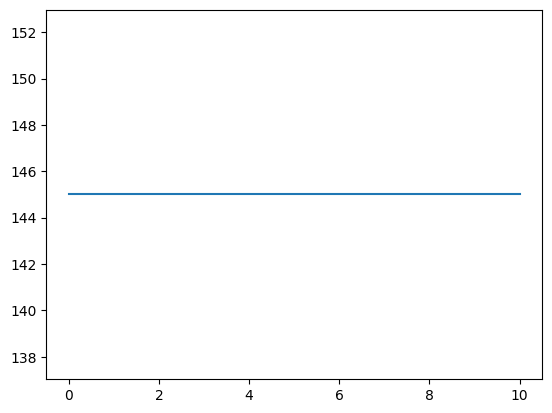

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


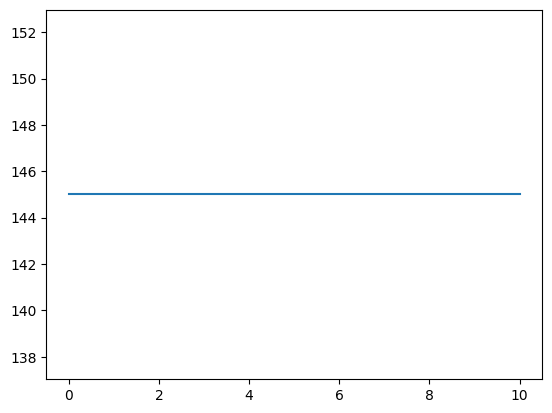

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


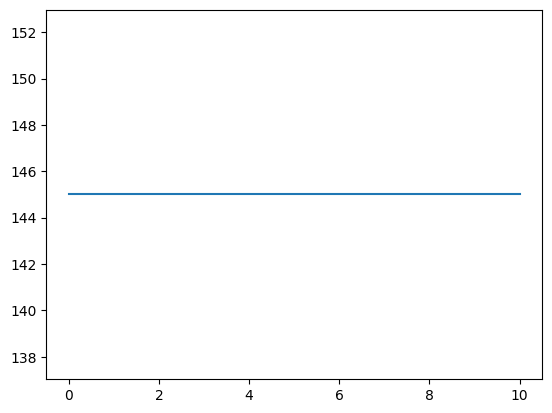

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


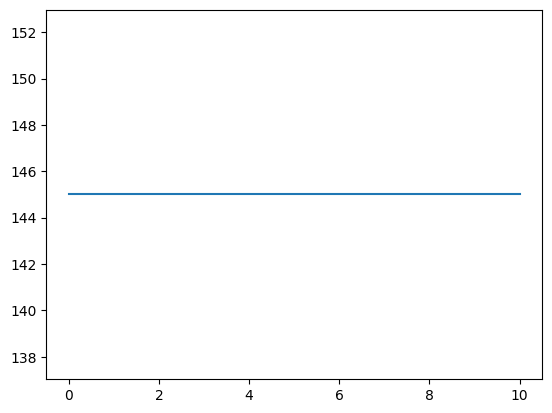

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


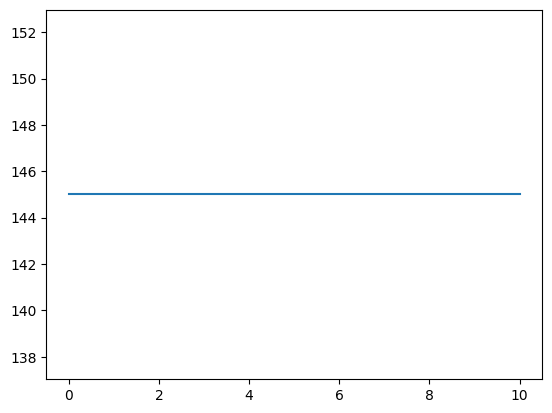

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 145
generacion 0, (Mejor fitness = 145)
Mejor individuo en la ultima generacion = [1, 1, 0, 0, 0, 0] (fitness = 145)


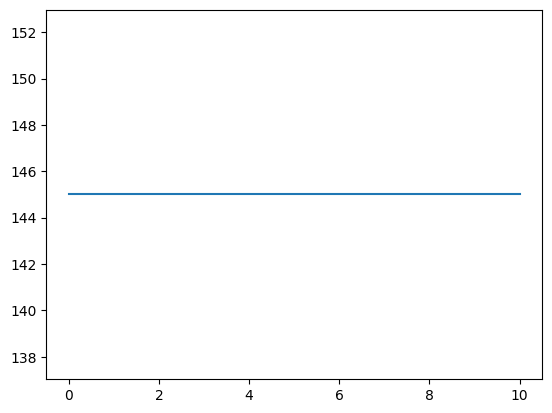

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


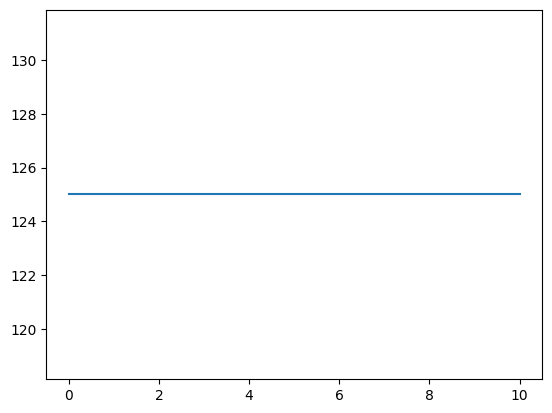

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


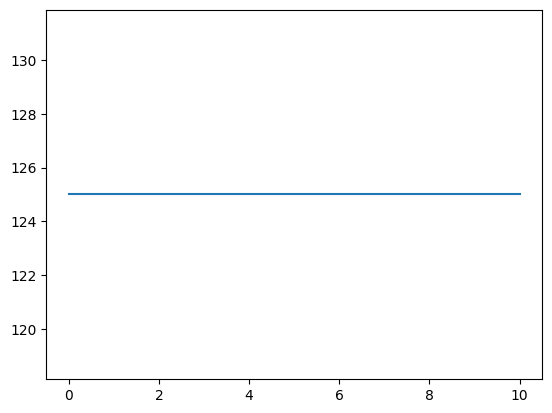

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


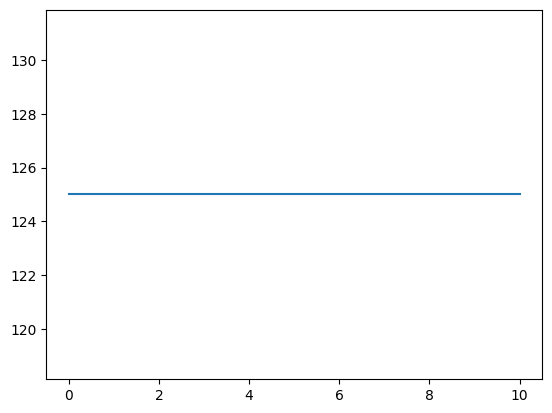

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


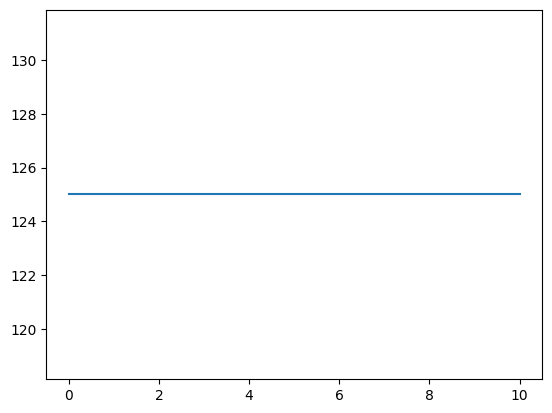

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


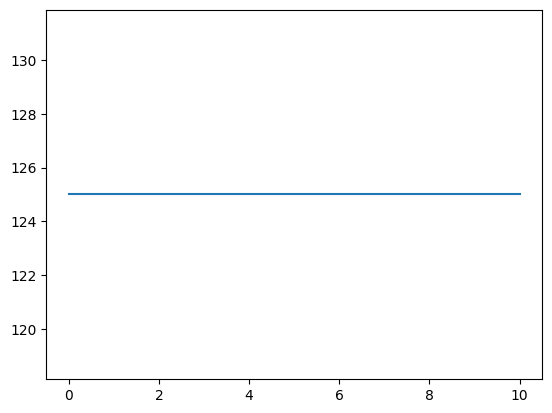

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


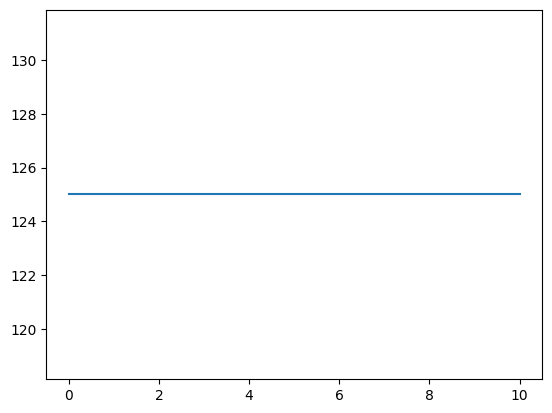

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


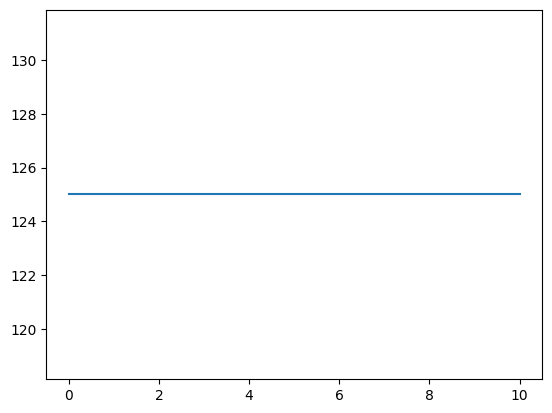

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


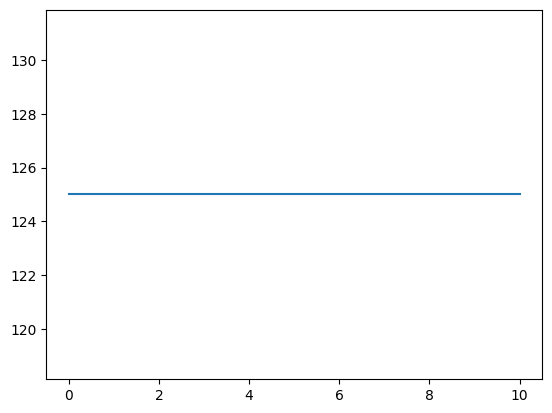

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


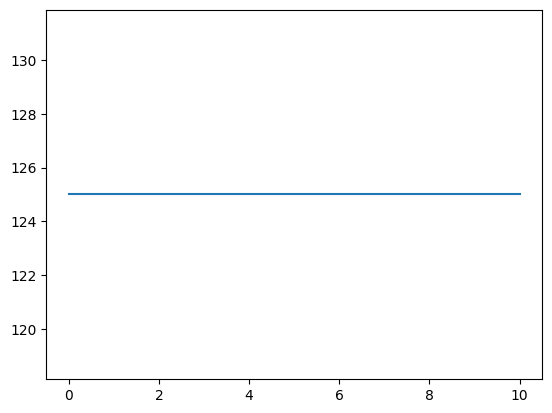

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 125
generacion 0, (Mejor fitness = 125)
Mejor individuo en la ultima generacion = [0, 0, 1, 0] (fitness = 125)


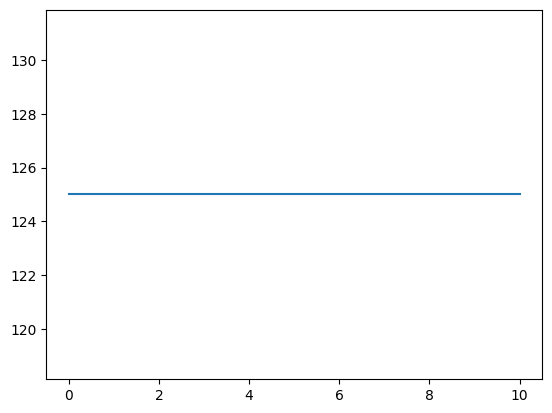

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


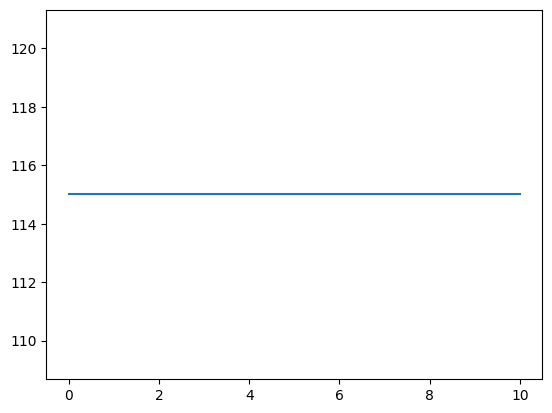

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


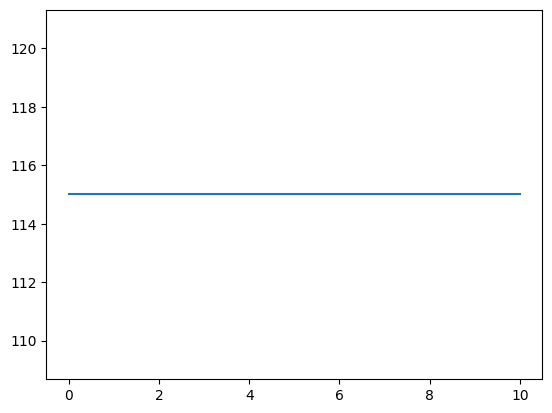

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


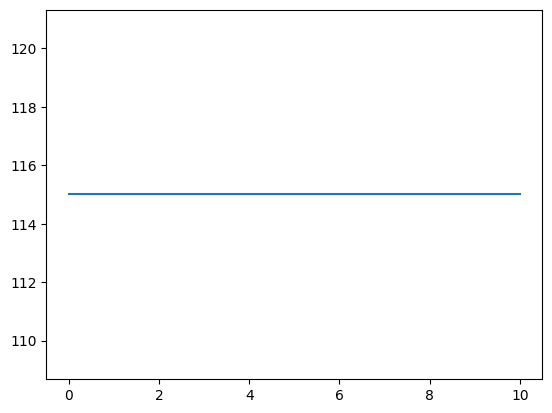

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


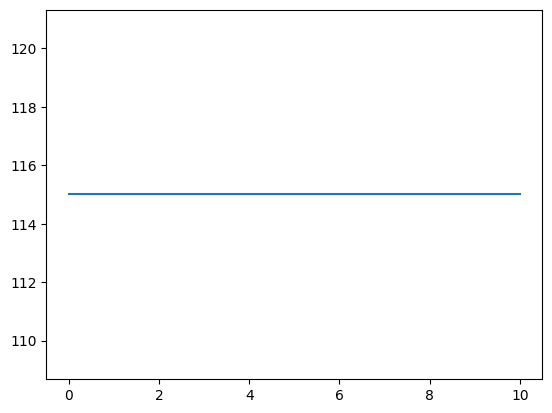

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


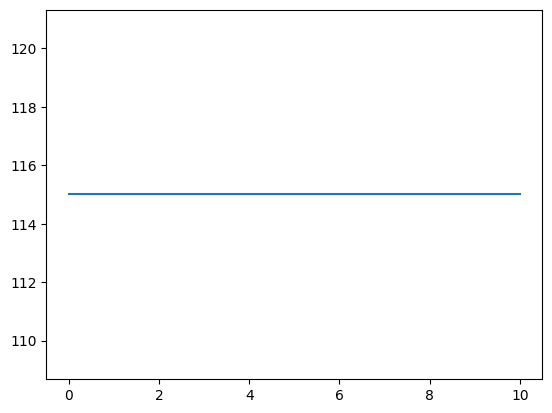

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


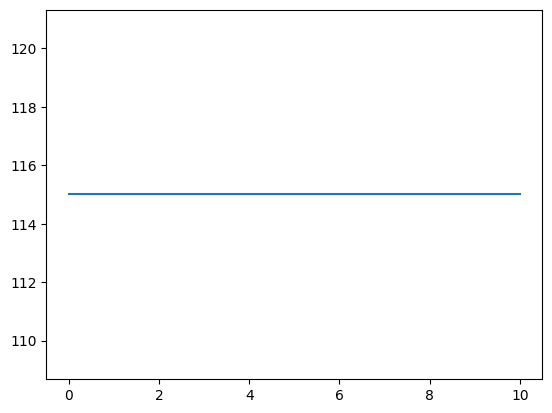

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


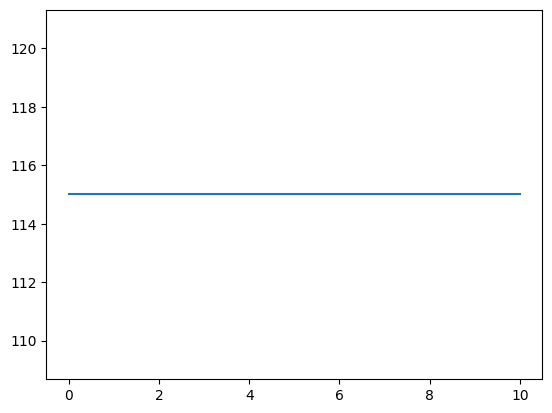

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


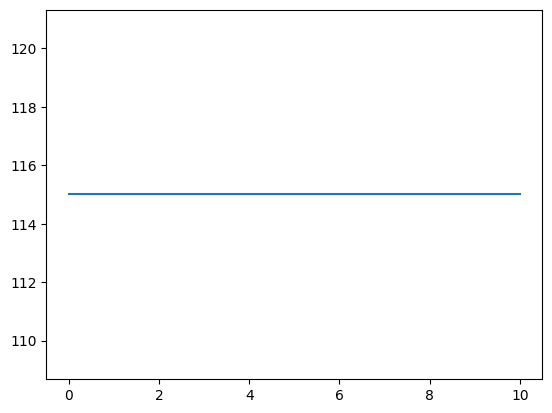

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


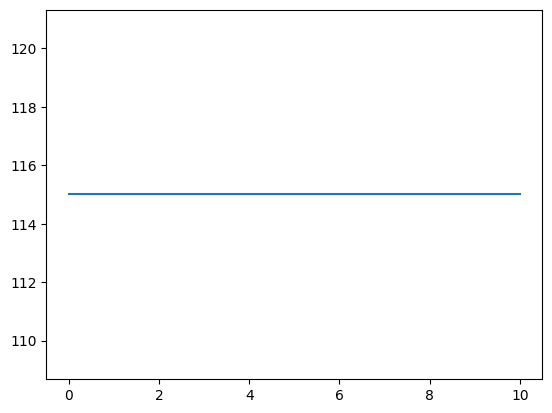

----------------------------------------
maxima posicion:  0
----------------------------------------
Poblacion inicial, best_fitness = 115
generacion 0, (Mejor fitness = 115)
Mejor individuo en la ultima generacion = [0, 1, 0] (fitness = 115)


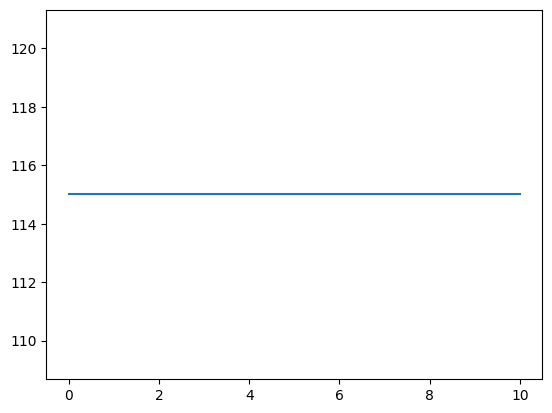

----------------------------------------
maxima posicion:  0
----------------------------------------


In [179]:
## Hiperparametros del algoritmo genetico
ItemPool = [ Item(Random_items[x]) for x in range (0,NUM_ITEMS) ]
MAX_WEIGHT = 15*len(ItemPool)    # maximo peso que puede soportar cada BIN

POPSIZE = 50       # numero de individuos
GENERATIONS = 10   # numero de generaciones
PMUT = 0.7       # taza de mutacion
NUM_BINS=5

## Inicializa una poblacion inicial de forma aleatoria
poblacion_inicial =  init_population(POPSIZE, NUM_ITEMS)
Items_guardados_bin=[]      #Almacenar el valor de los pesos de cada BIN
Elementos_no_elegidos=[]    #Almacenar los pesos que no fueron colocados en ningun BIN al culminar el proceso

mean_first_generation=[]
mode_first_generation=[]

for j in range(NUM_BINS):
  for i in range(10):
    best_ind, bestfitness, index_fitness = genetic_algorithm(poblacion_inicial, ItemPool, MAX_WEIGHT, GENERATIONS, PMUT, 
                                              crossover="onepoint", mutation="flip", 
                                              selection_parents_method = 'roulette', 
                                              selection_survivors_method = 'ranking')

    
    plt.plot(bestfitness)
    plt.show()

    max_pos=0
    max_valor=0

    for k in range(len(bestfitness)):
      if bestfitness[k]>max_valor:
        max_valor=bestfitness[k]
        max_pos=k

    array_first_generation_max.append(max_pos)
    print("-"*40)
    print("maxima posicion:  " + str(max_pos))
    print("-"*40)
  mean=statistics.mean(array_first_generation_max)
  moda=statistics.mode(array_first_generation_max)

  mean_first_generation.append(mean)
  mode_first_generation.append(moda)


  #Guardar items de cada BIN
  Item_en_bin=[]
  

  for z in range(len(ItemPool)):
    if index_fitness[z]==1:
      Item_en_bin.append(ItemPool[z])

  Items_guardados_bin.append(Item_en_bin)

  #Actualiza los items faltantes y la poblacion nueva
  Aux_item_pool=ItemPool
  ItemPool=[]
  for q in range(len(Aux_item_pool)):
    if index_fitness[q]==0:
      ItemPool.append(Aux_item_pool[q])

  poblacion_inicial =  init_population(POPSIZE, len(ItemPool))

  if j==(NUM_BINS-1):
    for p in range(len(Aux_item_pool)):
      if index_fitness[p]==0:
        Elementos_no_elegidos.append(Aux_item_pool[p])

In [180]:
mean_first_generation

[0.7333333333333333, 0.8538461538461538, 0.7928571428571428, 0.74, 0.69375]

In [181]:
mode_first_generation

[0, 0, 0, 0, 0]

In [182]:
Area_total_no_usada=0

print("Metodo de cruzamiento onepoint y tasa de mutacion 0.7")

for k in range(len(Items_guardados_bin)):
  Area_usada=0
  print("Para el bin numero {}".format(k+1))
  for i in range(len(Items_guardados_bin[k])):
    print("  peso: " + str(Items_guardados_bin[k][i].weight))
    Area_usada+=Items_guardados_bin[k][i].weight
    
  print("Area no usada: " + str(150-Area_usada) + "\n"+"-"*40)
  Area_total_no_usada+=(150-Area_usada)

print("Area total no usada: " + str(Area_total_no_usada))

Metodo de cruzamiento onepoint y tasa de mutacion 0.7
Para el bin numero 1
  peso: 50
  peso: 100
Area no usada: 0
----------------------------------------
Para el bin numero 2
  peso: 80
  peso: 70
Area no usada: 0
----------------------------------------
Para el bin numero 3
  peso: 60
  peso: 85
Area no usada: 5
----------------------------------------
Para el bin numero 4
  peso: 125
Area no usada: 25
----------------------------------------
Para el bin numero 5
  peso: 115
Area no usada: 35
----------------------------------------
Area total no usada: 65


In [183]:
print("Pesos no elegidos: ")

for i in range(len(Elementos_no_elegidos)):
  print("  peso: " + str(Elementos_no_elegidos[i].weight))

Pesos no elegidos: 
  peso: 110
  peso: 95
